<h2><center>Furniv - EDA</center></h2>
<p>As part of any data analysis process, an initial exploratory phase is required to familiarize with the data and to find new information on the issue evaluated. That is how, by reviewing and cleaning the data and by plotting different variables in diferent formats, new insight is gathered and proper modeling aproximations are proposed. 
    
<p></p>As so, we started reviewing the data with the idea of getting initial information on how historical sales affected the behavior of the stock and the product portfolio.</p>
<p>First we cleaned all tables to have a standarized, relevant data with no outliers, NaN values and precise working information. We also created some new fields for some tables to be able to work on differents asspects such as dates, quentities and categorical variables. Finally we merged some tables to have aditional information os the sales and current stock of the client's company. Here we can see the `.info()` descriptor of our tables:</p>

In [121]:
import statsmodels.api as sm

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
## Librerias
from io import StringIO as Buf
import re
import numpy                 as np
import pandas                as pd
import matplotlib.pyplot     as plt
import seaborn               as sns
from IPython.display import display_html
from itertools import chain,cycle
import plotly.express as px

## Funciones
def get_data():
    stock = pd.read_csv('~/Proyecto/Data/ExistenciasNew.csv')
    sales = pd.read_csv('~/Proyecto/Data/FacturacionCorregida.csv',parse_dates=['Fecha'],dayfirst=True ,sep=';')
    products = pd.read_csv('~/Proyecto/Data/MaestroCorregido.csv', sep=';')
    return stock, sales, products

def clean_products(products):
    products.columns = [column.upper() for column in products.columns]
    products.columns = [column.lstrip('001-') for column in products.columns]
    products.columns = [column.replace('.', '') for column in products.columns]
    products.columns = [column.replace(' ', '_') for column in products.columns]
    products.columns = [column.replace('_EXHIBIDO', '') for column in products.columns]
    products.columns = [column.replace('_UNIFICADA', '') for column in products.columns]
    products = products.rename(columns={
        'DESC_ITEM':'DESC_LARGA',
        'DESC_EXT_1_DETALLE':'DETALLE_1',
        'DESC_EXT_2_DETALLE':'DETALLE_2',
        'DESC_TIPO_INVENTARIO':'TIPO_INVENTARIO',
        'DEPARTAMENTO':'CATEGORIA',
        'MATERIAL_PPAL':'MATERIAL',
        'PUESTOS':'PUESTOS_STR',
        'NUM_PUESTOS':'PUESTOS',
        'REF_COMBINADA':'REF',
        'COLOR_DEF':'COLOR',
    })

    regex = '^([A-Z0-9]+\s\-\s)+'
    products.SUBCATEGORIA = products.SUBCATEGORIA.str.replace(regex,'',regex=True)
    products.ORIGEN = products.ORIGEN.str.replace(regex,'',regex=True)
    products.CATEGORIA = products.CATEGORIA.str.replace(regex,'',regex=True)
    products.ESTILO = products.ESTILO.str.replace(regex,'',regex=True)
    products.VIGENCIA = products.VIGENCIA.str.replace(regex,'',regex=True)
    products.MATERIAL = products.MATERIAL.str.replace(regex,'',regex=True).str.upper()
    products.ACABADO = products.ACABADO.str.upper().replace('SUPERFICIES MATE','MATE')
    products.DETALLE_1.fillna('N/A',inplace=True)
    products.DETALLE_2.fillna('N/A',inplace=True)
    products['PUESTOS'] = products.PUESTOS_STR.str.slice(stop=1).replace({'N':0,'M':7}).astype(int).replace({0:np.nan})
    products = products[['ITEM','REF','DESCRIPCION','CATEGORIA','SUBCATEGORIA','VIGENCIA','ORIGEN',
                         'ESTILO','MATERIAL','ACABADO','PUESTOS','COLOR','ANCHO','ALTO','FONDO','DESC_LARGA']]
    return products

def clean_sales(sales):
    sales.columns = [column.upper() for column in sales.columns]
    sales.columns = [column.replace('.', '') for column in sales.columns]
    sales.columns = [column.replace(' ', '_') for column in sales.columns]
    sales = sales.groupby(['CO','DESC_CO','NRO_DOCUMENTO','REF_COMBINADA','FECHA'])[['CANTIDAD_INV','SUMA_DE_VLR_BRUTO','SUMA_DE_VLR_SUBTOTAL']].sum().reset_index()
    sales['ID'] = sales['CO'].astype(str)+':'+sales['NRO_DOCUMENTO']+':'+sales['REF_COMBINADA']
    sales["DESCUENTO(%)"] = (sales['SUMA_DE_VLR_BRUTO']-sales['SUMA_DE_VLR_SUBTOTAL'])/sales['SUMA_DE_VLR_BRUTO']
    sales['PRECIO'] = sales['SUMA_DE_VLR_BRUTO']/sales['CANTIDAD_INV']
    sales['MES'] = sales['FECHA'].dt.month
    sales['ANIO'] = sales['FECHA'].dt.year
    sales['DIA'] = sales['FECHA'].dt.weekday
    sales = sales.rename(columns={
        'CO':'CODIGO_TIENDA',
        'DESC_CO':'TIENDA',
        'REF_COMBINADA':'PROD_REF',
        'CANTIDAD_INV':'CANTIDAD',
        'SUMA_DE_VLR_BRUTO':'SUBTOTAL',
        'SUMA_DE_VLR_SUBTOTAL':'TOTAL',
    })
    sales = sales[['ID','NRO_DOCUMENTO','FECHA','CODIGO_TIENDA','TIENDA','PROD_REF','CANTIDAD','PRECIO',
                   'SUBTOTAL','DESCUENTO(%)','TOTAL','ANIO','MES','DIA']]
    return sales

def clean_stock(stock):
    stock.columns = [column.upper() for column in stock.columns]
    stock.columns = [column.replace('.', '') for column in stock.columns]
    stock.columns = [column.replace(' ', '_') for column in stock.columns]
    
    stock = stock.rename(columns={
        'EXT_1_DETALLE':'DETALLE_1',
        'EXT_2_DETALLE':'DETALLE_2',
        'REF_COMBINADA':'REF',
        'REFERENCIA':'ID',
        'DISP':'CANTIDAD',
        'DEPARTAMENTO':'CATEGORIA'
    })
    
    regex = '^([A-Z0-9]+\s\-\s)+'
    stock.CATEGORIA = stock.CATEGORIA.str.replace(regex,'',regex=True)
    stock.SUBCATEGORIA = stock.SUBCATEGORIA.str.replace(regex,'',regex=True)
    
    stock = stock[['ID','REF','CANTIDAD','CATEGORIA','SUBCATEGORIA','DETALLE_1','DETALLE_2']]
    return stock

def create_merges(sales,products):
    sales_prod = sales.merge(products, left_on='PROD_REF', right_on='REF')
    stock_prod = stock.drop(columns=['CATEGORIA','SUBCATEGORIA']).merge(products, on='REF', how='left')
    return sales_prod, stock_prod

def create_categories(sales):
    pareto_subcat = []
    temp = sales_prod.groupby('SUBCATEGORIA')["CANTIDAD"].sum().sort_values(ascending=False)
    totalSales = temp.sum()
    pareto = totalSales*0.8
    counter = 0
    
    temp = temp.to_frame().reset_index()
    for index, row in temp.iterrows():
        counter += row["CANTIDAD"]
        pareto_subcat.append(row["SUBCATEGORIA"])
        if counter >= pareto:
            break
    return pareto_subcat

def add_category_pos(row):
    if row["SUBCATEGORIA"] in categories:
        index = row["SUBCATEGORIA"]
    else:
        index = "OTROS"
    return index

def add_pos_cols(sales_prod):
    sales_prod["SUBCATEGORIA_POS"] = sales_prod.apply(add_category_pos,axis = 1 )
    sales_prod['COLOR_POS'] = np.where(sales_prod["COLOR"].isin(['NEGRO', 'GRIS', 'CAFE', 'BLANCO', 'AZUL', 'MIEL', 'BEIGE', 'CRISTAL',
       'ROJO', 'AMARILLO']), sales_prod["COLOR"], 'OTRO')
    return sales_prod

def create_references(sales_prod):
    references = sales_prod.groupby('REF').aggregate(
        CANTIDAD=pd.NamedAgg(column="CANTIDAD", aggfunc="sum"),
        TOTAL=pd.NamedAgg(column="TOTAL", aggfunc="sum"), 
        PRECIO_PROMEDIO=pd.NamedAgg(column='PRECIO',aggfunc='mean'),
        DESCUENTO_PROMEDIO=pd.NamedAgg(column='DESCUENTO(%)', aggfunc= 'mean')
    ).reset_index().merge(products, on='REF').sort_values(by='CANTIDAD', ascending=False)
    ref_materials = references.groupby(['MATERIAL'])['CANTIDAD'].sum().sort_values(ascending=False)
    cumpperce = ref_materials.cumsum()/ref_materials.sum()*100
    ref_materials = cumpperce[cumpperce<91].to_frame().rename(columns={'CANTIDAD':'CANTIDAD(%)'})
    return references, ref_materials

def df_mat_mod(df):
    df['MATERIAL_POS']=df['MATERIAL'].copy()
    df['MATERIAL_POS'].loc[~df['MATERIAL'].isin(ref_materials.index)] = 'otros'
    return

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str += '<th style="text-align:center"><td style="vertical-align:top">'
        html_str += f'<h4>{title}</h4>'
        html_str += df.to_html().replace('table','table style="display:inline"')
        html_str += '</td></th>'
    display_html(html_str,raw=True)
    return

def print_clean_output(df):
    buffer = Buf()
    df.info(buf=buffer)
    s = buffer.getvalue()
    s = re.sub('(\A(.*\n){3})|((\n.*\n.*){1}$)','',s)
    print(s)

In [7]:
stock, sales, products = get_data()
products = clean_products(products)
sales = clean_sales(sales)
stock = clean_stock(stock)
sales_prod, stock_prod = create_merges(sales,products)
categories = create_categories(sales)

add_pos_cols(sales_prod)
add_pos_cols(products)
add_pos_cols(stock_prod)

references, ref_materials = create_references(sales_prod)

df_mat_mod(products)
df_mat_mod(sales_prod)
df_mat_mod(stock_prod)
df_mat_mod(references)

### Products:

In [8]:
print_clean_output(products)

 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ITEM              1285 non-null   int64  
 1   REF               1285 non-null   object 
 2   DESCRIPCION       1285 non-null   object 
 3   CATEGORIA         1285 non-null   object 
 4   SUBCATEGORIA      1285 non-null   object 
 5   VIGENCIA          1285 non-null   object 
 6   ORIGEN            1285 non-null   object 
 7   ESTILO            1285 non-null   object 
 8   MATERIAL          1285 non-null   object 
 9   ACABADO           1285 non-null   object 
 10  PUESTOS           1017 non-null   float64
 11  COLOR             1285 non-null   object 
 12  ANCHO             1285 non-null   float64
 13  ALTO              1285 non-null   float64
 14  FONDO             1285 non-null   float64
 15  DESC_LARGA        1285 non-null   object 
 16  SUBCATEGORIA_POS  1285 non-null   object 
 17  COLOR_POS         1285 non-null   object 
 18  MATERIAL_POS      1285 non-null   object 



### Sales:

In [9]:
print_clean_output(sales)

 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ID             36050 non-null  object        
 1   NRO_DOCUMENTO  36050 non-null  object        
 2   FECHA          36050 non-null  datetime64[ns]
 3   CODIGO_TIENDA  36050 non-null  int64         
 4   TIENDA         36050 non-null  object        
 5   PROD_REF       36050 non-null  object        
 6   CANTIDAD       36050 non-null  int64         
 7   PRECIO         36050 non-null  float64       
 8   SUBTOTAL       36050 non-null  int64         
 9   DESCUENTO(%)   36050 non-null  float64       
 10  TOTAL          36050 non-null  int64         
 11  ANIO           36050 non-null  int64         
 12  MES            36050 non-null  int64         
 13  DIA            36050 non-null  int64         



### Stock:

In [10]:
print_clean_output(stock)

 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            941 non-null    object 
 1   REF           941 non-null    object 
 2   CANTIDAD      941 non-null    int64  
 3   CATEGORIA     941 non-null    object 
 4   SUBCATEGORIA  941 non-null    object 
 5   DETALLE_1     877 non-null    float64
 6   DETALLE_2     75 non-null     float64



Sales with product merge:

In [11]:
print_clean_output(sales_prod)

 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID                36180 non-null  object        
 1   NRO_DOCUMENTO     36180 non-null  object        
 2   FECHA             36180 non-null  datetime64[ns]
 3   CODIGO_TIENDA     36180 non-null  int64         
 4   TIENDA            36180 non-null  object        
 5   PROD_REF          36180 non-null  object        
 6   CANTIDAD          36180 non-null  int64         
 7   PRECIO            36180 non-null  float64       
 8   SUBTOTAL          36180 non-null  int64         
 9   DESCUENTO(%)      36180 non-null  float64       
 10  TOTAL             36180 non-null  int64         
 11  ANIO              36180 non-null  int64         
 12  MES               36180 non-null  int64         
 13  DIA               36180 non-null  int64         
 14  ITEM              36180 non-null  int64         
 15  REF               36180 non-null  object        
 16  DESCRIPCION       36180

Stock with product merge:

In [12]:
print_clean_output(stock_prod)

 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                943 non-null    object 
 1   REF               943 non-null    object 
 2   CANTIDAD          943 non-null    int64  
 3   DETALLE_1         879 non-null    float64
 4   DETALLE_2         75 non-null     float64
 5   ITEM              452 non-null    float64
 6   DESCRIPCION       452 non-null    object 
 7   CATEGORIA         452 non-null    object 
 8   SUBCATEGORIA      452 non-null    object 
 9   VIGENCIA          452 non-null    object 
 10  ORIGEN            452 non-null    object 
 11  ESTILO            452 non-null    object 
 12  MATERIAL          452 non-null    object 
 13  ACABADO           452 non-null    object 
 14  PUESTOS           312 non-null    float64
 15  COLOR             452 non-null    object 
 16  ANCHO             452 non-null    float64
 17  ALTO              452 non-null    float64
 18  FONDO             452 non-null    float64
 19  DESC_LAR

## Sales analysis

To continue with analysis, we started by reviewing the sales behavior to find information about the most important products for the company according to the amount of items sold. Here we can see the total value of the items sold during the last tree years.

Text(0.5, 1.0, 'Ventas Totales\n')

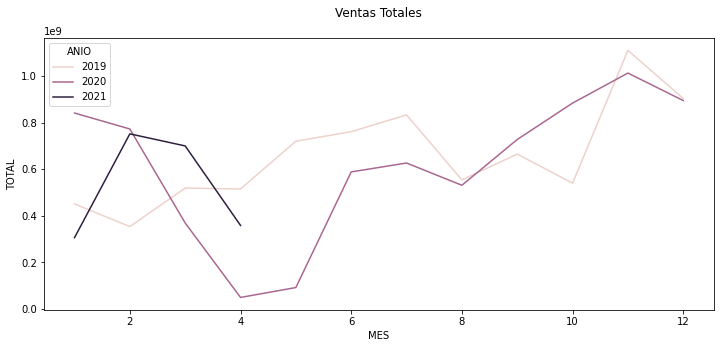

In [13]:
sales1 = sales.groupby(['ANIO','MES'])['TOTAL'].sum().to_frame().reset_index()
fig, axes = plt.subplots(1, 1,figsize=(12,5))
sns.lineplot(data=sales1, x="MES", y='TOTAL', hue="ANIO")
plt.title('Ventas Totales\n')

In the graph we can see different behaviors. Fist we observe a normal year with a growing welling trend with peak during the last months of the year. The, for 2020 se wee the efects of the COVID pandemic restritions imposed by the colombian goverment during March, April and May, and then again a normal, thought slower, grouth trend to again gain a peak performance during October,  November and December. And finally we have this years data that has a cut up to April 15 which explains the low behavior of that month compared to the, presumed growth, of 2019.

In the second graph we have the average sale value of every month. in there we confirmed the suspission that even though the pandemic affected the amount of sales made during that period, the sales that were made had a similar mean value from the previous year and the following year. Which in turn translates on the general idea that the company has a really similar average sale value every month and that what cheanges is the anmount of sales made each period.

Text(0.5, 1.0, 'Ventas por periodo')

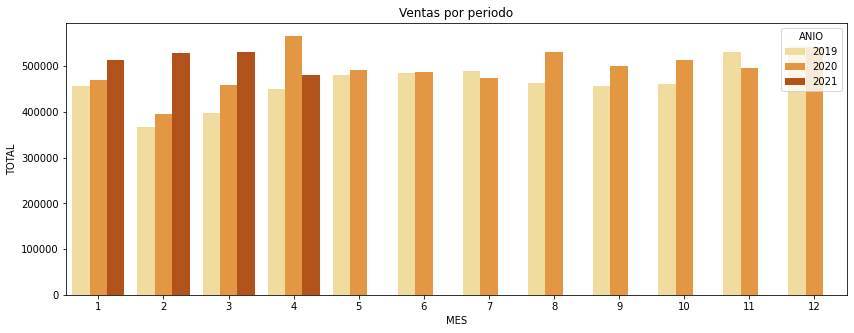

In [14]:
sales1 = sales.groupby(['ANIO','MES'])['TOTAL'].mean().to_frame().reset_index()
fig, axes = plt.subplots(1, 1,figsize=(14,5))
sns.barplot(data=sales1, x="MES", y='TOTAL', hue="ANIO",  palette="YlOrBr")
plt.title('Ventas por periodo')

In this reggard we can see that the average sales per year for the company is arround 7,600 MM. In 2019 of 7,923MM, in 2020 7,387MM and up to Arpil 2021 of 2,116MM. All of which allows us to clonclude that 2020 was, nonetheless the efects of the pandemic, a really positive and profitable year for the company. In facty the company was able to considerably recover to almost get the same values from 2019.

In relation to 2021 sales, we can also see that they have a 15% increase vs. 2019 del 15% and about 4% vs. 2020. A favorable anual company growth.

<AxesSubplot:title={'center':'Frecuencia de la cantidad de ventas\n'}, xlabel='SUBCATEGORIA_POS', ylabel='CATEGORIA'>

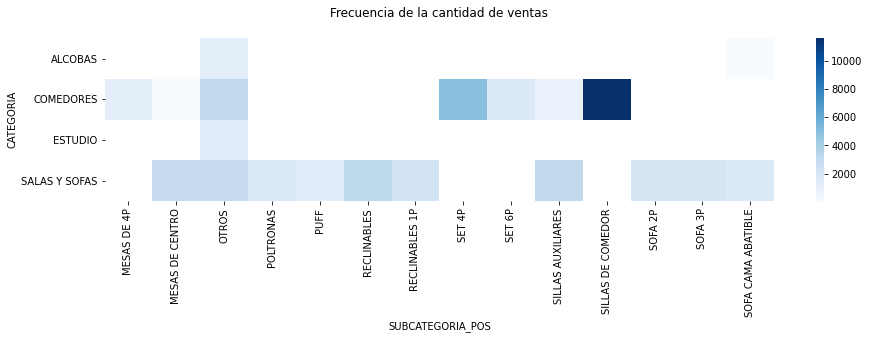

In [15]:
fig,ax=plt.subplots(figsize=(15,3))
ax.set_title('Frecuencia de la cantidad de ventas\n')
sns.heatmap(pd.pivot_table(data=references,index='CATEGORIA',columns='SUBCATEGORIA_POS',values='CANTIDAD',aggfunc='sum'),cmap='Blues')

<AxesSubplot:title={'center':'Frecuencia del valor de venta\n'}, xlabel='SUBCATEGORIA_POS', ylabel='CATEGORIA'>

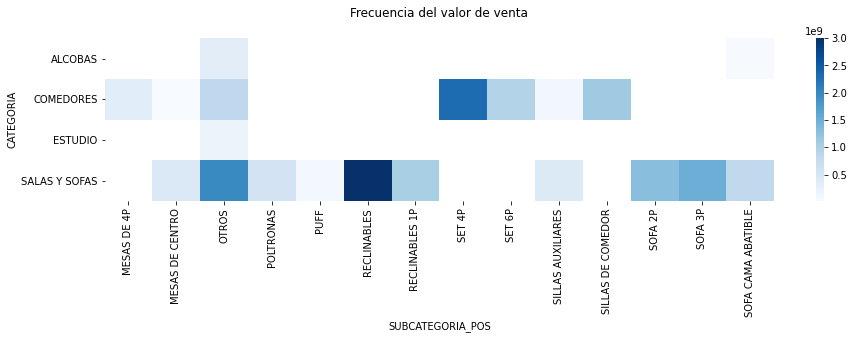

In [16]:
fig,ax=plt.subplots(figsize=(15,3))
ax.set_title('Frecuencia del valor de venta\n')
sns.heatmap(pd.pivot_table(data=references,index='CATEGORIA',columns='SUBCATEGORIA_POS',values='TOTAL',aggfunc='sum'),cmap='Blues', robust=True)

### Characterized sold portfolio

Now we started to get information on some of the characteristicas of the sold portfolio of the company. Firts we see the distribution in relation to the product origin, the store it was sold and the main sub categories sold. Then we reviewed the information of the products of those sub categories to check the style and the colors that where most chosen.

Text(0.5, 1.0, 'Ventas por Origen de Portafolio\n')

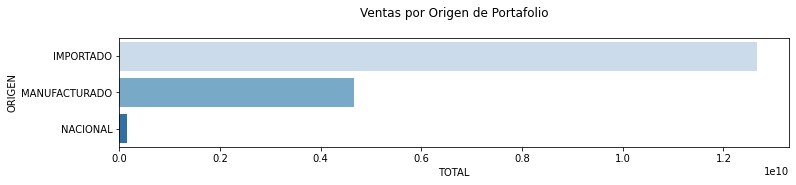

In [17]:
grafico = sales_prod.groupby('ORIGEN')['TOTAL'].sum().sort_values(ascending=False).to_frame().reset_index().head(10)
fig, axes = plt.subplots(1, 1,figsize=(12,2))
sns.barplot(data=grafico, y='ORIGEN', x='TOTAL', palette="Blues")
plt.title('Ventas por Origen de Portafolio\n')

We can see here that the company's sold posrtfolio is comprised of imported products, with a 68% of the sold portfolio, and fabricated prodcuts with almost 30% of the portfolio; leaving the other categories with less than 2%.

Text(0.5, 1.0, 'Ventas por tienda\n')

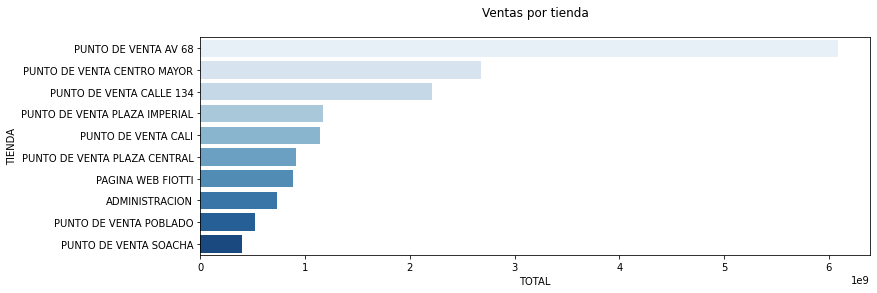

In [18]:
grafico = sales_prod.groupby('TIENDA')['TOTAL'].sum().sort_values(ascending=False).to_frame().reset_index().head(10)
fig, axes = plt.subplots(1, 1,figsize=(12,4))
sns.barplot(data=grafico, y='TIENDA', x='TOTAL', palette="Blues")
plt.title('Ventas por tienda\n')

In this second graph we observe that most of the sales where made in Bogotá in phisical stores (the fisrt 4 stores comprise almost the 70% of the total sold portfolio), followed by sales from Cali and the webpage.

Next, we can review that the top 13 sub categories of products sold, wich is almost 80% of the total sold portfolio, are dining and living room elements with dinning room chairs with an exsesive amount sold.

<AxesSubplot:xlabel='FECHA', ylabel='CANTIDAD'>

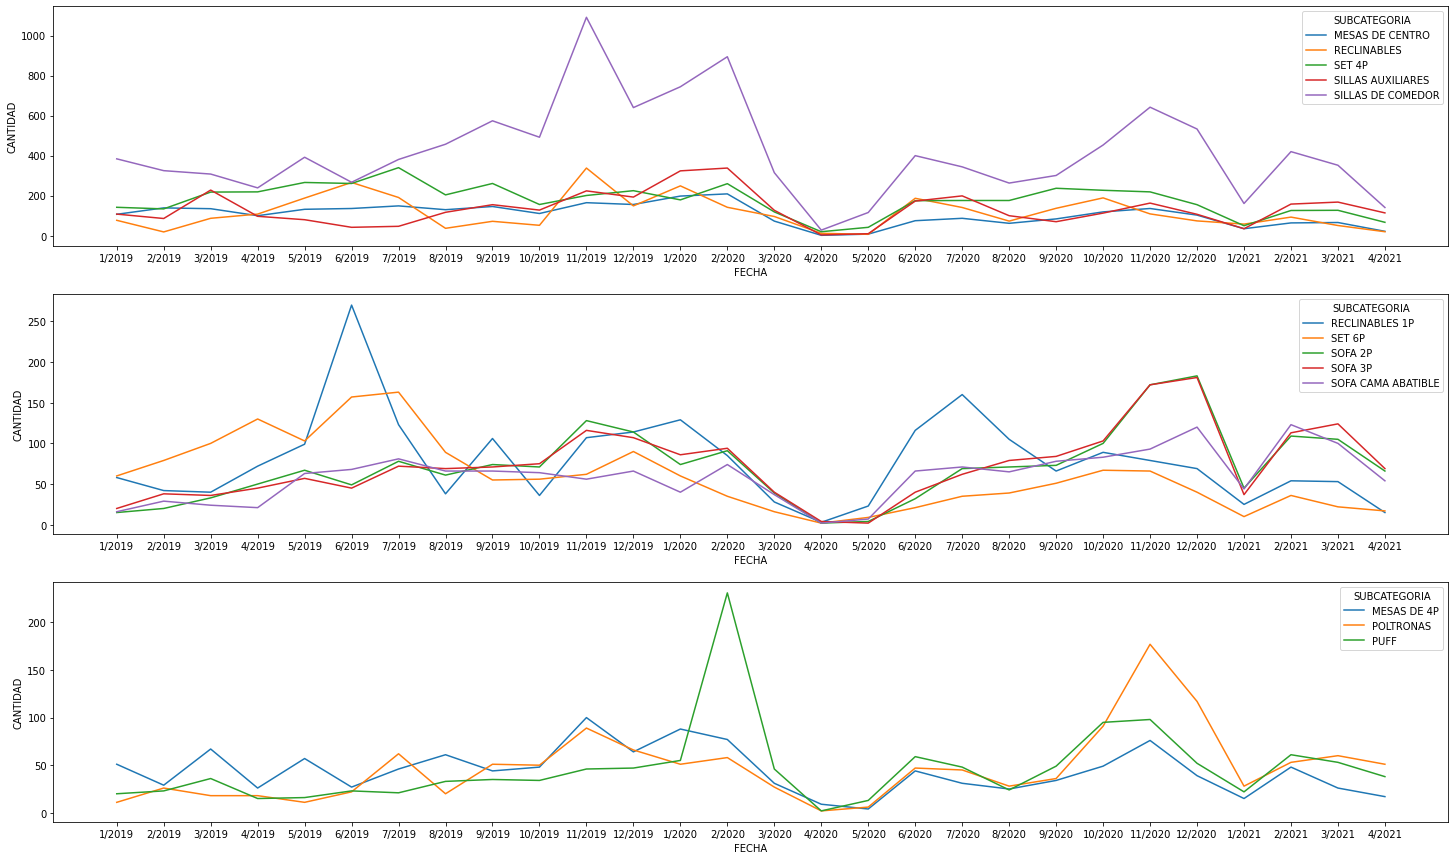

In [19]:
top5 = sales_prod[sales_prod["SUBCATEGORIA"].isin(categories[:5])]
top5 = top5.groupby(by=["MES", "ANIO", "SUBCATEGORIA"])["CANTIDAD"].sum().to_frame().reset_index().sort_values(by=['ANIO','MES'])
top5["FECHA"] = top5.apply(lambda x: str(x["MES"])+"/"+str(x["ANIO"]) ,axis=1)
top10 = sales_prod[sales_prod["SUBCATEGORIA"].isin(categories[5:10])]
top10 = top10.groupby(by=["MES", "ANIO", "SUBCATEGORIA"])["CANTIDAD"].sum().to_frame().reset_index().sort_values(by=['ANIO','MES'])
top10["FECHA"] = top10.apply(lambda x: str(x["MES"])+"/"+str(x["ANIO"]) ,axis=1)
topRest = sales_prod[sales_prod["SUBCATEGORIA"].isin(categories[10:15])]
topRest = topRest.groupby(by=["MES", "ANIO", "SUBCATEGORIA"])["CANTIDAD"].sum().to_frame().reset_index().sort_values(by=['ANIO','MES'])
topRest["FECHA"] = topRest.apply(lambda x: str(x["MES"])+"/"+str(x["ANIO"]) ,axis=1)

fig, axes = plt.subplots(3, 1,figsize=(25,15))
sns.lineplot(ax=axes[0],data=top5, x="FECHA", y="CANTIDAD", hue="SUBCATEGORIA")
sns.lineplot(ax=axes[1],data=top10, x="FECHA", y="CANTIDAD", hue="SUBCATEGORIA")
sns.lineplot(ax=axes[2],data=topRest, x="FECHA", y="CANTIDAD", hue="SUBCATEGORIA")

As of this point is still not completly clear if for each element a particular month is relevant or not. Nonetheless it seems that on september each year perople are more willing to buy furniture for the dinning room that on other months. On the graph we can also see selling peaks for some elemnts in november due to BlackFriday.

Here we have the top 5 selling products with their respective amount sold since 2019 and a plot tracing the relation between the value of the sold elements in the portfolio and the amount sold of each of those elements.

In [20]:
sales_prod.groupby(['SUBCATEGORIA'])['CANTIDAD'].sum().sort_values(ascending=False).head(5)

SUBCATEGORIA
SILLAS DE COMEDOR    11657
SET 4P                4982
SILLAS AUXILIARES     3708
RECLINABLES           3222
MESAS DE CENTRO       2949
Name: CANTIDAD, dtype: int64

In [21]:
plt.figure()
px.scatter(references,
           x="CANTIDAD",
           y="TOTAL",
           color="SUBCATEGORIA",
           hover_data=['REF', 'DESC_LARGA','CATEGORIA','PRECIO_PROMEDIO'],
           title="\t Sales Category | Money vs Units")

<Figure size 432x288 with 0 Axes>

As mentioned now we present the most representative styles and colors for the sold portfolio.

Text(0.5, 1.0, 'Ventas por Estilo\n')

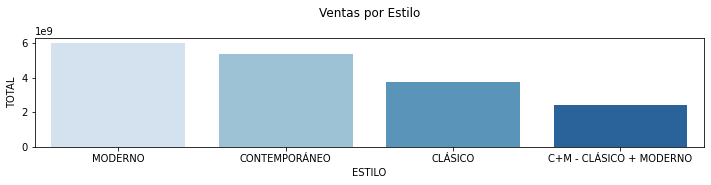

In [22]:
grafico = sales_prod.groupby('ESTILO')['TOTAL'].sum().sort_values(ascending=False).to_frame().reset_index().head(10)
fig, axes = plt.subplots(1, 1,figsize=(12,2))
sns.barplot(data=grafico, x='ESTILO', y='TOTAL', palette="Blues")
plt.title('Ventas por Estilo\n')

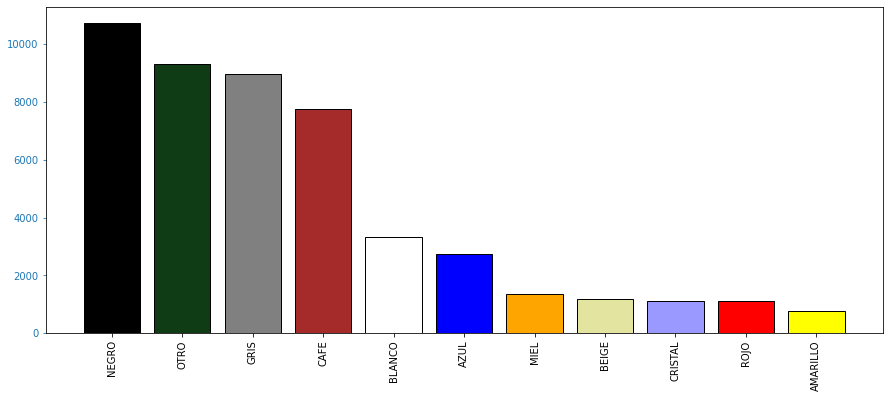

In [23]:
par_col = sales_prod[['COLOR_POS','CANTIDAD']].groupby('COLOR_POS').sum().sort_values(by = 'CANTIDAD',ascending = False)
par_col["cumpercentage"] = par_col["CANTIDAD"].cumsum()/par_col["CANTIDAD"].sum()*100
palette = ["#000000", "#0f3c14",  "#808080", "#A52A2A", "#FFFFFF", "#0000FF", "#FFA500", "#e4e4a1", "#9999ff", "#ff0000", "#FFFF00"]

fig, ax = plt.subplots(figsize=(15,6))
ax.bar(par_col.index, par_col["CANTIDAD"], color=palette, edgecolor='black')
ax.tick_params(axis="y", colors="C0")
ax.tick_params(axis="x", labelrotation = 90)

##ax2 = ax.twinx()
##ax2.plot(par_col.index, par_col["cumpercentage"], color="C1", marker="D", ms=7)
##ax2.yaxis.set_major_formatter(PercentFormatter())
##ax2.tick_params(axis="y", colors="C1")

plt.show()

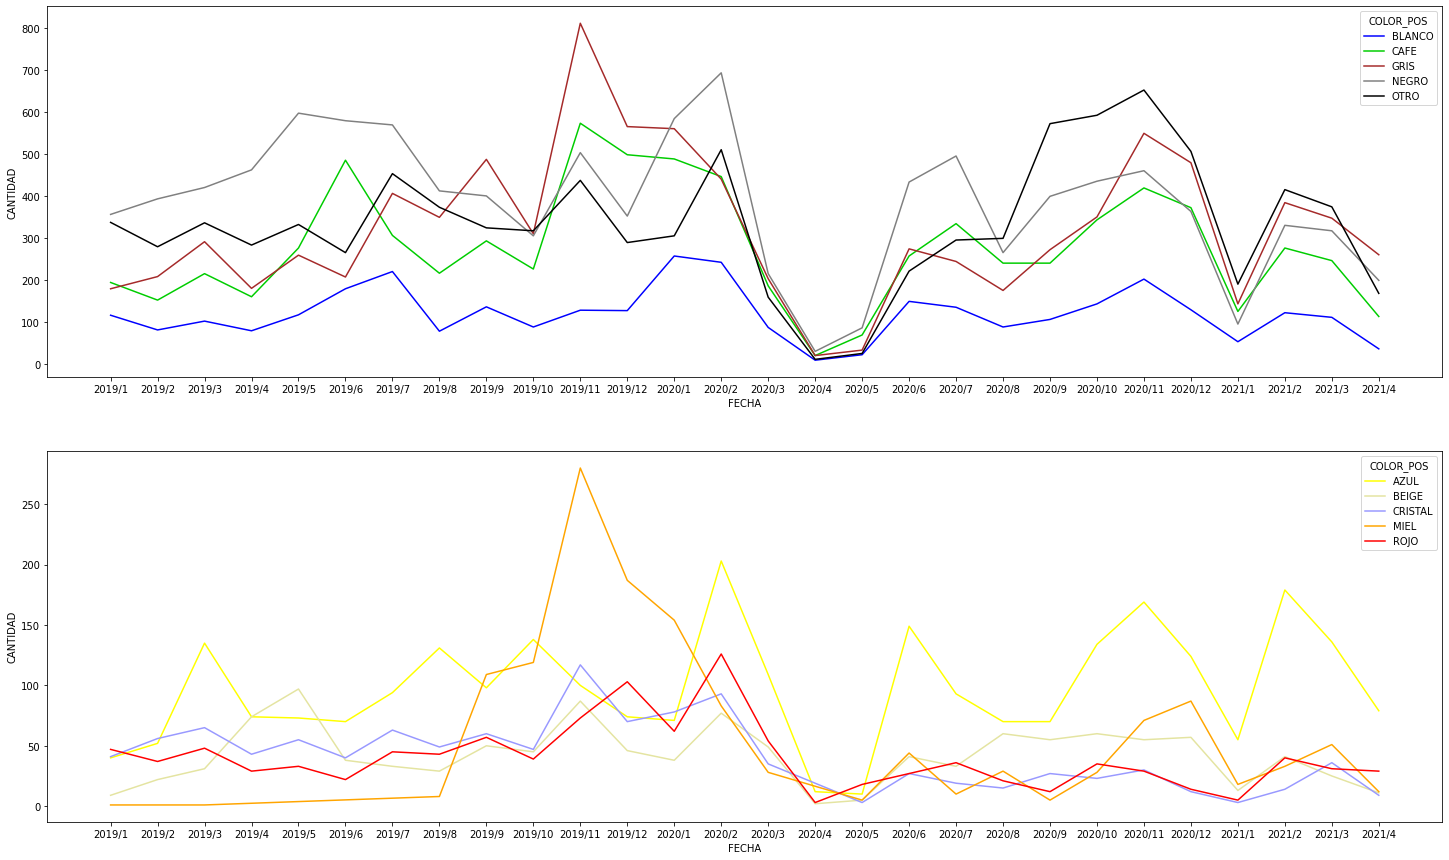

In [24]:
top_color_5 = sales_prod[sales_prod["COLOR_POS"].isin(par_col.index[:5])]
top_color_10 = sales_prod[sales_prod["COLOR_POS"].isin(par_col.index[5:10])]
top_color_5 = top_color_5.groupby(by=["MES", "ANIO", "COLOR_POS"])["CANTIDAD"].sum().to_frame().reset_index().sort_values(by=['ANIO','MES'])
top_color_10 = top_color_10.groupby(by=["MES", "ANIO", "COLOR_POS"])["CANTIDAD"].sum().to_frame().reset_index().sort_values(by=['ANIO','MES'])

top_color_10["FECHA"] = top_color_10.apply(lambda x: str(x["ANIO"])+"/"+str(x["MES"]) ,axis=1)
top_color_5["FECHA"] = top_color_5.apply(lambda x: str(x["ANIO"])+"/"+str(x["MES"]) ,axis=1)


fig, axes = plt.subplots(2, 1,figsize=(25,15))
sns.lineplot(ax=axes[0],data=top_color_5, x="FECHA", y="CANTIDAD", hue="COLOR_POS", palette =["#0000FF","#00CD00","#A52A2A","#808080","#000000"])
sns.lineplot(ax=axes[1],data=top_color_10, x="FECHA", y="CANTIDAD", hue="COLOR_POS", palette = ["#FFFF00","#e4e4a1","#9999ff","#FFA500","#ff0000"])

plt.show()

## Products analysis

After reviewing the behavior of the sales during th past years we saw the oportunity to check whether the finding had relevant aditional information in relation to the actual composition of the whole portfolio, and the way each subcategory realtes to the "acabado", main material, number of seats and color.

Here we have a brief summary of the table and then the cross matrix between the chosen variables:

In [25]:
print_clean_output(products)

 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ITEM              1285 non-null   int64  
 1   REF               1285 non-null   object 
 2   DESCRIPCION       1285 non-null   object 
 3   CATEGORIA         1285 non-null   object 
 4   SUBCATEGORIA      1285 non-null   object 
 5   VIGENCIA          1285 non-null   object 
 6   ORIGEN            1285 non-null   object 
 7   ESTILO            1285 non-null   object 
 8   MATERIAL          1285 non-null   object 
 9   ACABADO           1285 non-null   object 
 10  PUESTOS           1017 non-null   float64
 11  COLOR             1285 non-null   object 
 12  ANCHO             1285 non-null   float64
 13  ALTO              1285 non-null   float64
 14  FONDO             1285 non-null   float64
 15  DESC_LARGA        1285 non-null   object 
 16  SUBCATEGORIA_POS  1285 non-null   object 
 17  COLOR_POS         1285 non-null   object 
 18  MATERIAL_POS      1285 non-null   object 



Text(0.5, 1.0, 'Frecuency of Department vs. Subcategory variables')

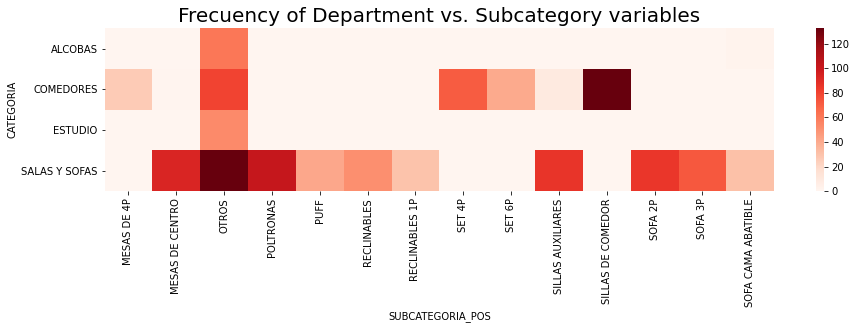

In [26]:
fig,ax=plt.subplots(figsize=(15,3))
sns.heatmap(pd.crosstab(products['CATEGORIA'],products['SUBCATEGORIA_POS']),cmap='Reds',robust=True,fmt='g')
plt.title('Frecuency of Department vs. Subcategory variables', fontsize=20)

Text(0.5, 1.0, 'Frecuency of Subcategories and "acabado"')

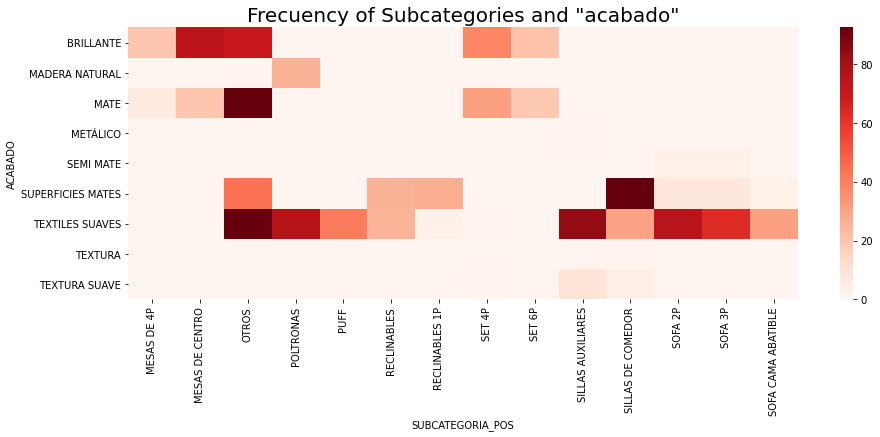

In [27]:
fig,ax=plt.subplots(figsize=(15,5))
sns.heatmap(pd.crosstab(products['ACABADO'],products['SUBCATEGORIA_POS']),cmap='Reds',robust=True,fmt='g')
plt.title('Frecuency of Subcategories and "acabado"', fontsize=20)

Text(0.5, 1.0, 'Frecuency of Subcategories and material')

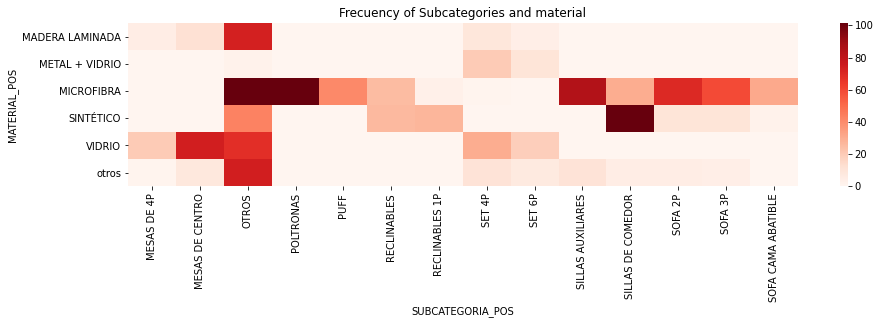

In [28]:
fig,ax=plt.subplots(figsize=(15,3))
sns.heatmap(pd.crosstab(products['MATERIAL_POS'],products['SUBCATEGORIA_POS']),cmap='Reds',robust=True,fmt='g')
plt.title('Frecuency of Subcategories and material')

Text(0.5, 1.0, 'Frecuency of Subcategories and puestos')

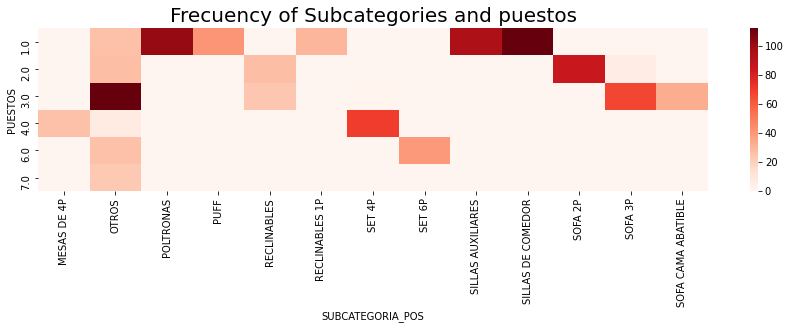

In [29]:
fig,ax=plt.subplots(figsize=(15,3))
sns.heatmap(pd.crosstab(products['PUESTOS'],products['SUBCATEGORIA_POS']),cmap='Reds',robust=True,fmt='g')
plt.title('Frecuency of Subcategories and puestos', fontsize=20)

Text(0.5, 1.0, 'Frecuency of Subcategories and colors')

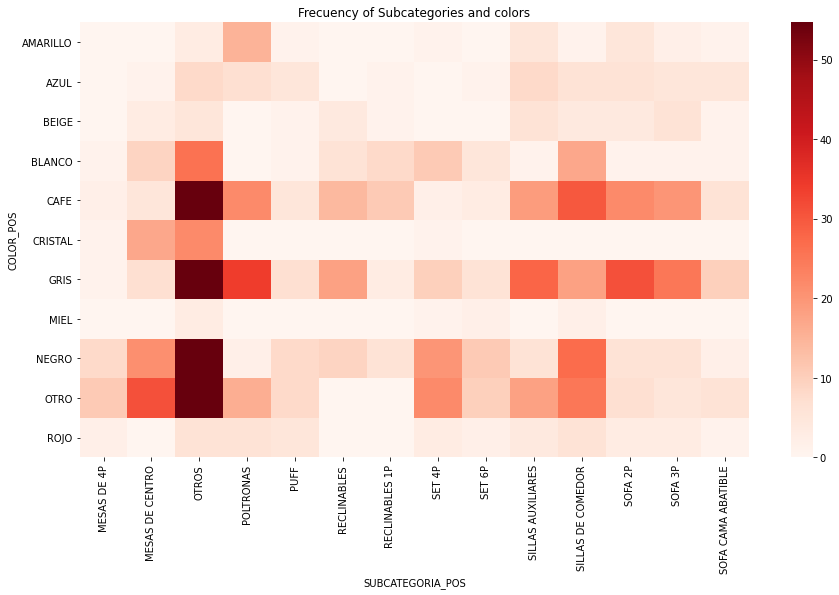

In [30]:
fig,ax=plt.subplots(figsize=(15,8))
sns.heatmap(pd.crosstab(products['COLOR_POS'],products['SUBCATEGORIA_POS']),cmap='Reds',robust=True)
plt.title('Frecuency of Subcategories and colors')

By checking the previous frecuencies we can check how each categorized element is comprised and inform the way the whole portfolio tends to be alocated on specific colors, materials, "acabados" and number of seats. Which in turn also represent a correlation with the most sold elements viewed on the previous section.

Following we have some other data of the portfolio such as the correlation matrix between amount sold, value sold, price, discount, meassures, and number of seats to assert the considered relation between the price and the meassurements and number of seats.

<AxesSubplot:>

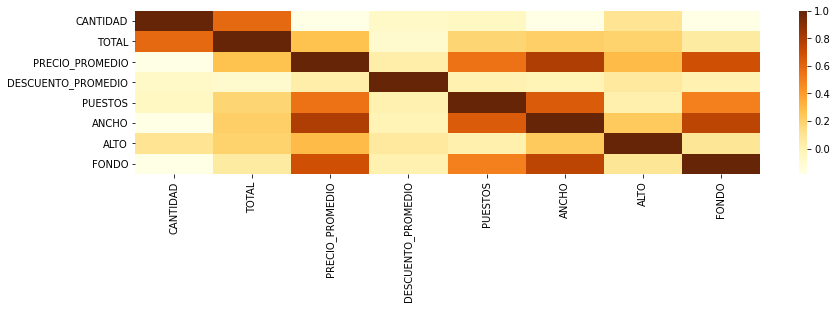

In [31]:
fig,ax=plt.subplots(figsize=(14,3))
df_refs_puestos=references.dropna(subset=['PUESTOS'])
sns.heatmap(df_refs_puestos.drop(columns='ITEM').corr(),cmap='YlOrBr')

# Linear regression analysis

In [32]:
from scipy import stats
import statsmodels.formula.api as smf

In [33]:
references.describe(include='O')

REF          DESCRIPCION      CATEGORIA  \
count                 1285                 1285           1285   
unique                1253                  592              4   
top     D01291:00132:00132  SILLA AUXILIAR BACO  SALAS Y SOFAS   
freq                     6                   40            806   

             SUBCATEGORIA       VIGENCIA     ORIGEN   ESTILO    MATERIAL  \
count                1285           1285       1285     1285        1285   
unique                 41              3          3        4          16   
top     SILLAS DE COMEDOR  DESCONTINUADO  IMPORTADO  MODERNO  MICROFIBRA   
freq                  136            678        798      544         594   

                ACABADO COLOR           DESC_LARGA SUBCATEGORIA_POS COLOR_POS  \
count              1285  1285                 1285             1285      1285   
unique                9    69                  904               14        11   
top     TEXTILES SUAVES  GRIS  SILLA AUXILIAR BACO            OTROS      GRIS   
freq                594   293                   40              408       293   

       MATERIAL_POS  
count          1285  
unique            6  
top      MICROFIBRA  
freq            594

In [34]:
references.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1285 entries, 1163 to 117
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   REF                 1285 non-null   object 
 1   CANTIDAD            1285 non-null   int64  
 2   TOTAL               1285 non-null   int64  
 3   PRECIO_PROMEDIO     1285 non-null   float64
 4   DESCUENTO_PROMEDIO  1285 non-null   float64
 5   ITEM                1285 non-null   int64  
 6   DESCRIPCION         1285 non-null   object 
 7   CATEGORIA           1285 non-null   object 
 8   SUBCATEGORIA        1285 non-null   object 
 9   VIGENCIA            1285 non-null   object 
 10  ORIGEN              1285 non-null   object 
 11  ESTILO              1285 non-null   object 
 12  MATERIAL            1285 non-null   object 
 13  ACABADO             1285 non-null   object 
 14  PUESTOS             1017 non-null   float64
 15  COLOR               1285 non-null   object 
 16  ANCH

array([[<AxesSubplot:title={'center':'CANTIDAD'}>,
        <AxesSubplot:title={'center':'TOTAL'}>,
        <AxesSubplot:title={'center':'PRECIO_PROMEDIO'}>],
       [<AxesSubplot:title={'center':'DESCUENTO_PROMEDIO'}>,
        <AxesSubplot:title={'center':'PUESTOS'}>,
        <AxesSubplot:title={'center':'ANCHO'}>],
       [<AxesSubplot:title={'center':'ALTO'}>,
        <AxesSubplot:title={'center':'FONDO'}>, <AxesSubplot:>]],
      dtype=object)

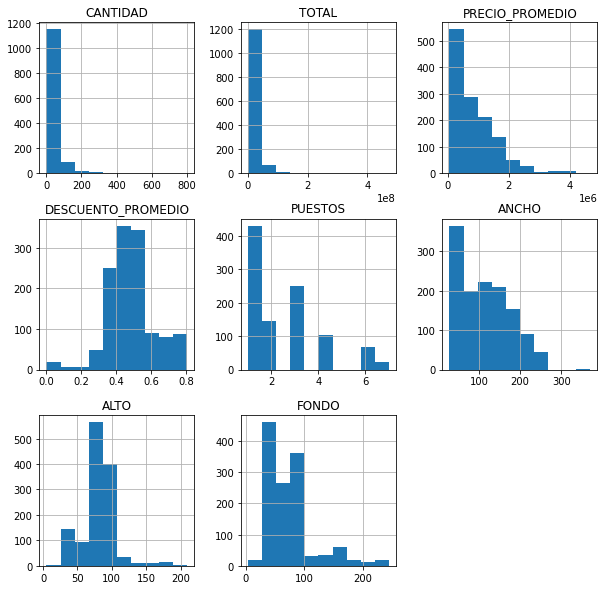

In [35]:
references.drop(columns='ITEM').hist(figsize=(10,10))

In [89]:
num_columns_plot=['PRECIO_PROMEDIO', 'ANCHO', 'ALTO', 'FONDO']
cat_columns_plot=['CATEGORIA', 'VIGENCIA',
       'ORIGEN', 'ESTILO', 'ACABADO', 'PUESTOS','SUBCATEGORIA_POS', 'COLOR_POS',
       'MATERIAL_POS']

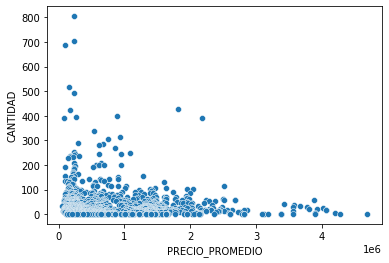

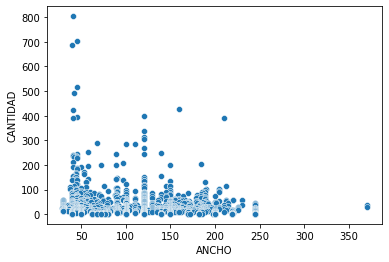

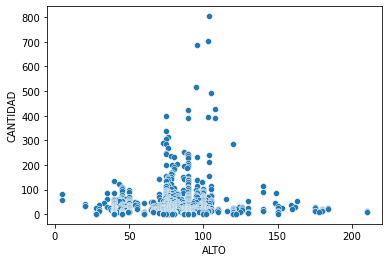

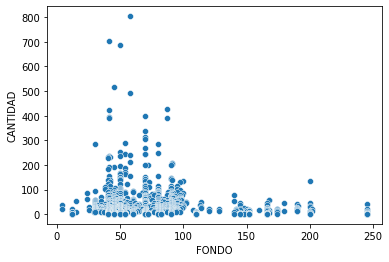

In [90]:
for i in num_columns_plot:
    plt.figure()
    sns.scatterplot(data=references,x=i,y='CANTIDAD')

fanning out phenomena

In [98]:
references[references['ACABADO']=='TEXTURA']

REF  CANTIDAD     TOTAL  PRECIO_PROMEDIO  DESCUENTO_PROMEDIO  \
845  XA0745:00011:       395  53908034    259827.942402            0.466342   

      ITEM              DESCRIPCION  CATEGORIA       SUBCATEGORIA VIGENCIA  \
845  18481  SILLA DE COMEDOR EUDAID  COMEDORES  SILLAS DE COMEDOR    LINEA   

        ORIGEN   ESTILO MATERIAL  ACABADO  PUESTOS COLOR  ANCHO   ALTO  FONDO  \
845  IMPORTADO  CLÁSICO   MADERA  TEXTURA      1.0  MIEL   46.0  103.0   41.0   

                       DESC_LARGA   SUBCATEGORIA_POS COLOR_POS MATERIAL_POS  
845  SILLA DE COMEDOR EUDAID MIEL  SILLAS DE COMEDOR      MIEL        otros

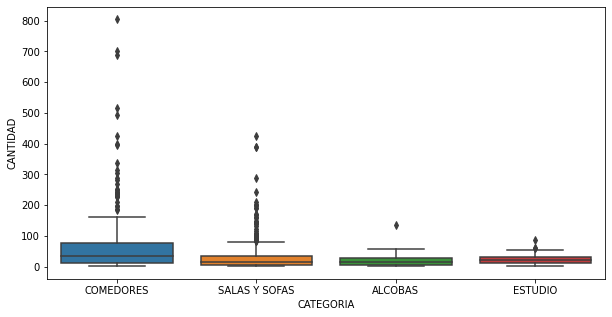

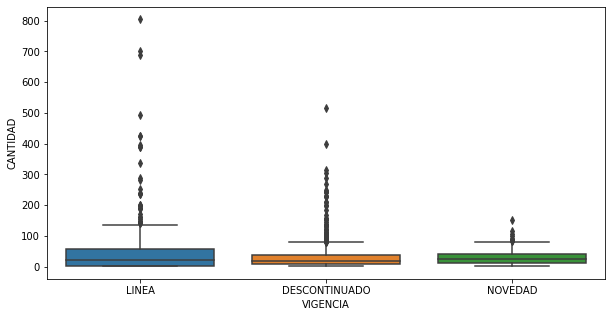

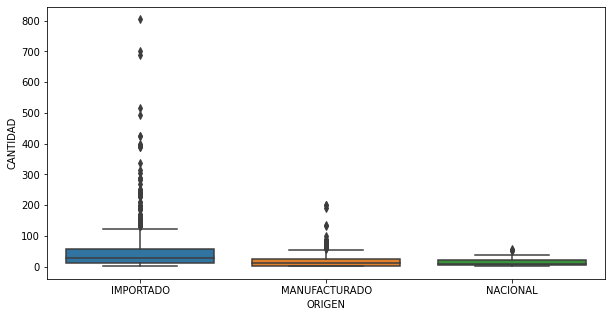

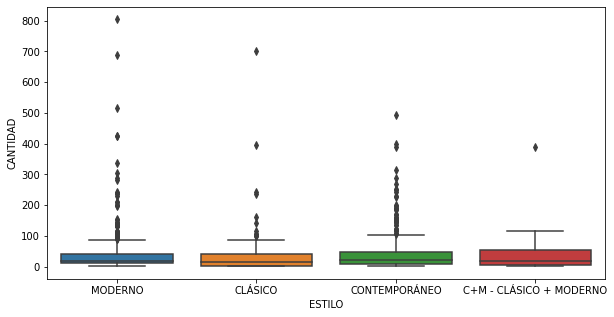

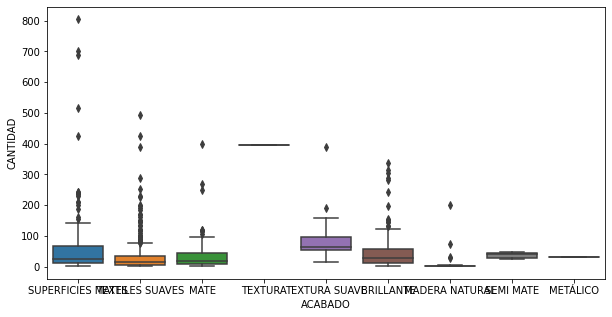

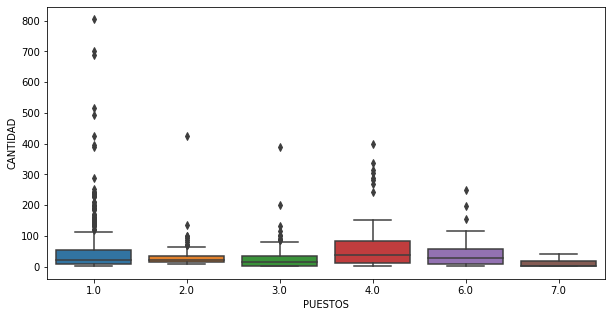

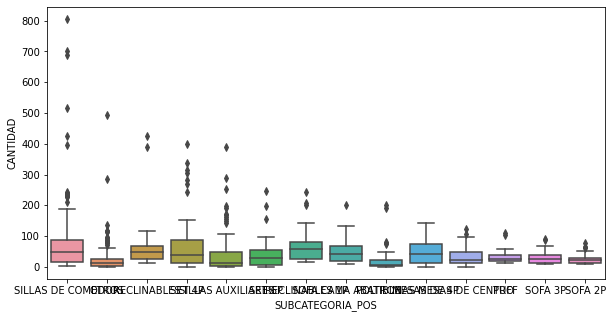

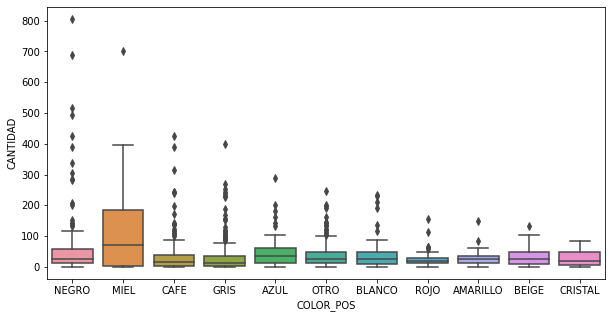

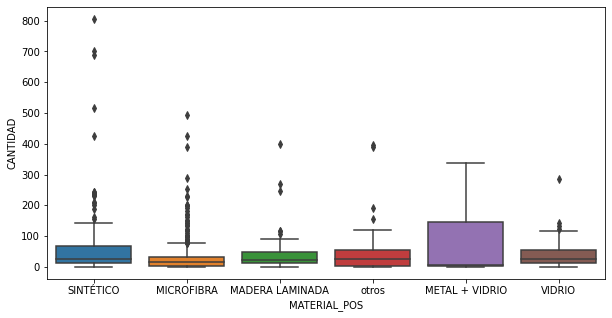

In [95]:
for i in cat_columns_plot:
    plt.figure(figsize=(10,5))
    sns.boxplot(data=references,x=i,y='CANTIDAD')

sin transformar

In [36]:
model1 = smf.ols(formula='CANTIDAD ~ PRECIO_PROMEDIO + DESCUENTO_PROMEDIO + ANCHO+ ALTO+FONDO', data=references).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               CANTIDAD   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     10.62
Date:                Mon, 02 Aug 2021   Prob (F-statistic):           5.18e-10
Time:                        22:07:18   Log-Likelihood:                -7129.4
No. Observations:                1285   AIC:                         1.427e+04
Df Residuals:                    1279   BIC:                         1.430e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             58.3283      9.357      6.233      0.000      39.971      76.686
PRECIO_PROMEDIO    -4.672e-06   3.94e-06     -1.186      0.236   -1.24e-05    3.06e-06
DESCUENTO_PROMEDIO   -44.7146     12.789     -3.496      0.000     -69.804     -19.626
ANCHO                 -0.1323      0.050     -2.664      0.008      -0.230      -0.035
ALTO                   0.2625      0.075      3.494      0.000       0.115       0.410
FONDO                 -0.0045      0.064     -0.070      0.944      -0.131       0.122
==============================================================================
Omnibus:                     1390.146   Durbin-Watson:                   0.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           101828.443
Skew:                           5.282   Prob(JB):                         0.00
Kurtosis:                      45.312   Cond. No.                     9.47e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.47e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

transformada

| If you get a lambda value ($λ$) of... 	| then transform $Y$ using this function 	|
|-	|-	|
| -3 	| $Y^{-3} = \frac{1}{Y^3}$ 	|
| -2 	| $Y^{-2} = \frac{1}{Y^2}$	|
| -1 	| $Y^{-1} = \frac{1}{Y^1}$ 	|
| -0.5 	| $Y^{-0.5} = \frac{1}{Y^{0.5}} = \frac{1}{\sqrt{Y}}$ 	|
| 0 	| $log(Y)$ 	|
| 0.5 	| $Y^{0.5} = \sqrt{Y}$ 	|
| 1 	| $Y^1 = Y$ 	|
| 2 	| $Y^2$ 	|
| 3 	| $Y^3$ 	|


In [37]:
references2=references.copy()

In [38]:
num_columns=['CANTIDAD','PRECIO_PROMEDIO', 'ANCHO', 'ALTO', 'FONDO'] #Descuento no se puede porque tiene 0
lambdas=[]
for column in num_columns:
    aux=stats.boxcox(references2[column])
    references2["{}_TRANSFORMADO".format(column)]=aux[0]
    lambdas.append(aux[1])
    print (column,aux[1])
    

CANTIDAD 0.12133743020159257
PRECIO_PROMEDIO 0.08665269023242199
ANCHO 0.2932399303313693
ALTO 0.5850708952489636
FONDO 0.05087748592216467


In [39]:
list(zip(num_columns,lambdas))

[('CANTIDAD', 0.12133743020159257),
 ('PRECIO_PROMEDIO', 0.08665269023242199),
 ('ANCHO', 0.2932399303313693),
 ('ALTO', 0.5850708952489636),
 ('FONDO', 0.05087748592216467)]

In [40]:
stats.boxcox(references2['PUESTOS'].dropna()) #toca tener cuidado con puestos, dropear antes de transformar

(array([0.        , 0.        , 0.        , ..., 0.93196132, 0.        ,
        0.        ]),
 -0.30817675394543215)

In [41]:
references2.columns

Index(['REF', 'CANTIDAD', 'TOTAL', 'PRECIO_PROMEDIO', 'DESCUENTO_PROMEDIO',
       'ITEM', 'DESCRIPCION', 'CATEGORIA', 'SUBCATEGORIA', 'VIGENCIA',
       'ORIGEN', 'ESTILO', 'MATERIAL', 'ACABADO', 'PUESTOS', 'COLOR', 'ANCHO',
       'ALTO', 'FONDO', 'DESC_LARGA', 'SUBCATEGORIA_POS', 'COLOR_POS',
       'MATERIAL_POS', 'CANTIDAD_TRANSFORMADO', 'PRECIO_PROMEDIO_TRANSFORMADO',
       'ANCHO_TRANSFORMADO', 'ALTO_TRANSFORMADO', 'FONDO_TRANSFORMADO'],
      dtype='object')

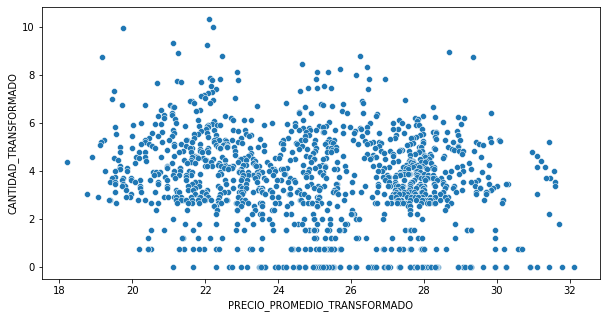

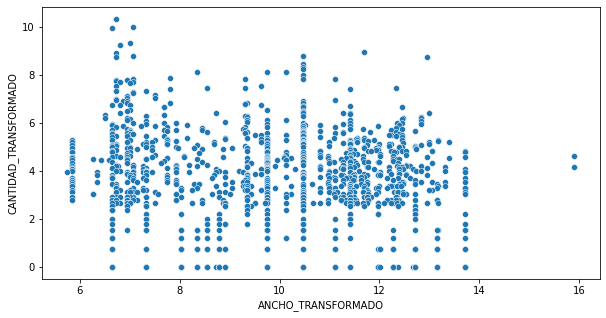

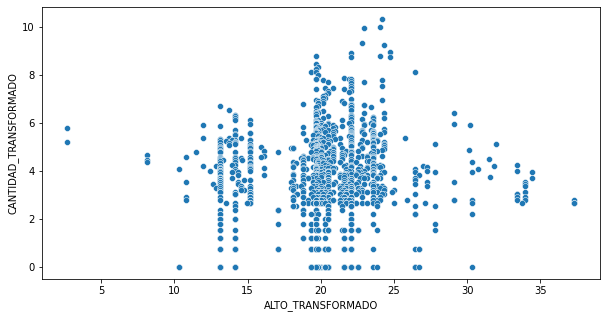

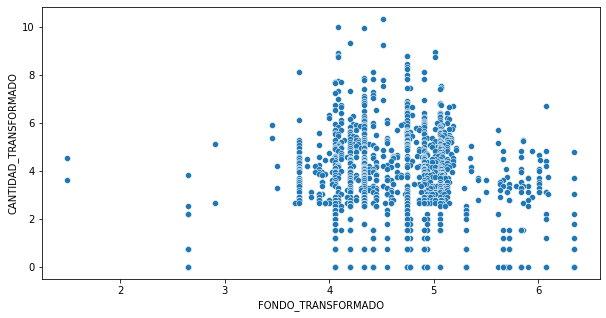

In [100]:
num_columns_transfor_plot=['PRECIO_PROMEDIO_TRANSFORMADO',
       'ANCHO_TRANSFORMADO', 'ALTO_TRANSFORMADO', 'FONDO_TRANSFORMADO']
for i in num_columns_transfor_plot:
    plt.figure(figsize=(10,5))
    sns.scatterplot(data=references2,y='CANTIDAD_TRANSFORMADO',x=i)

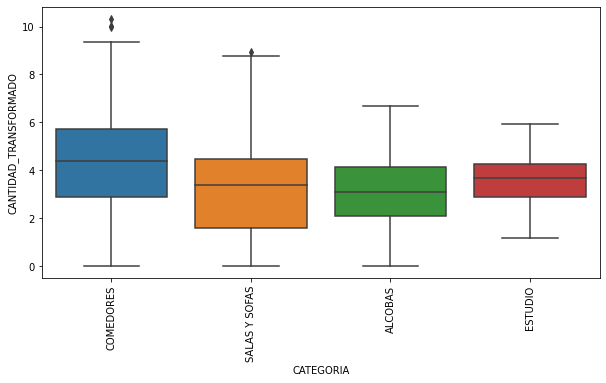

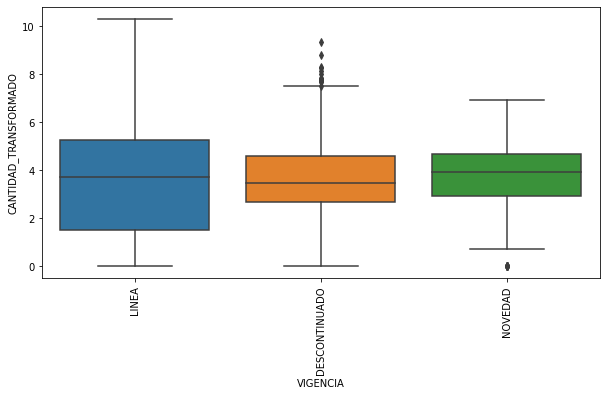

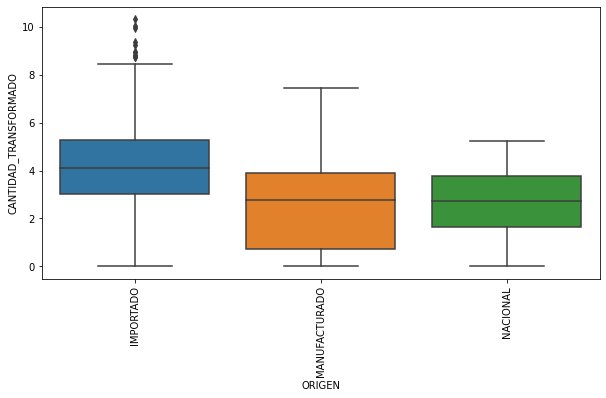

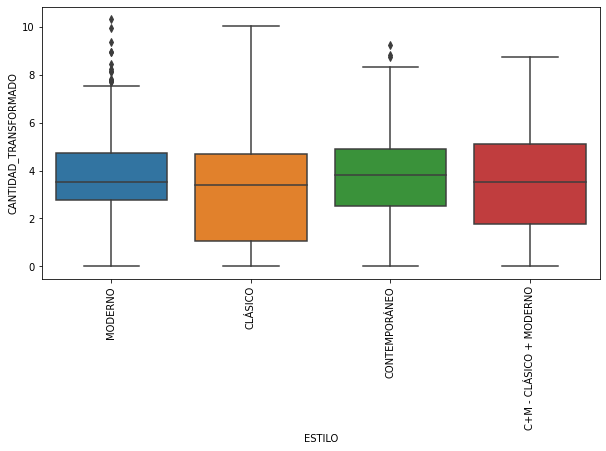

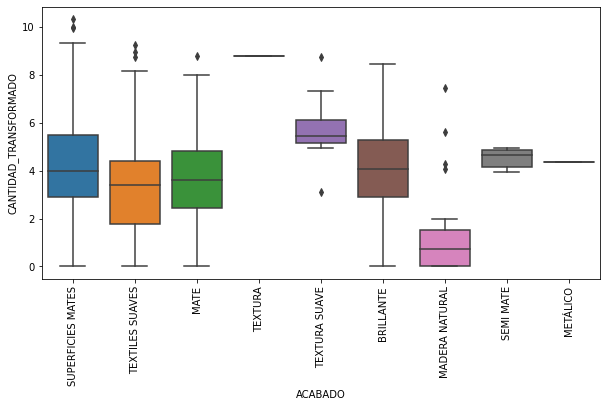

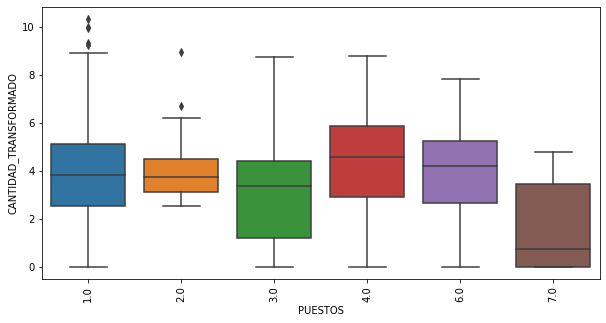

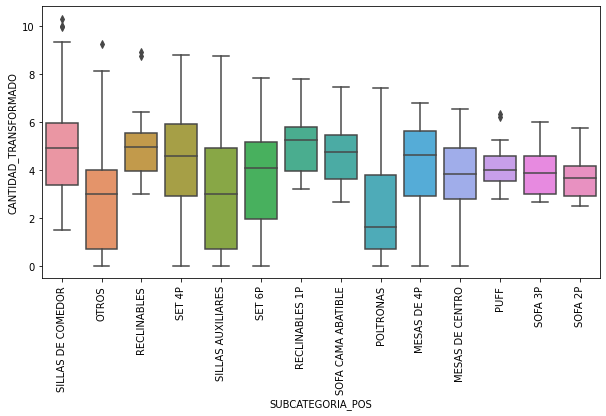

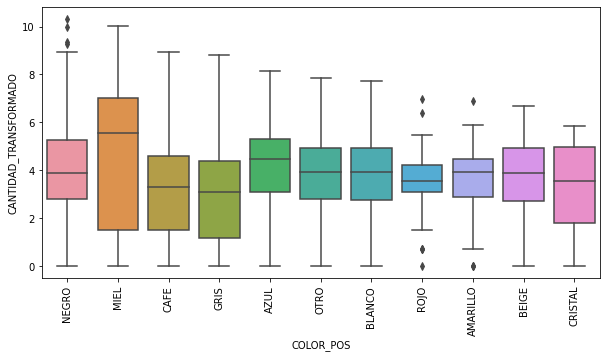

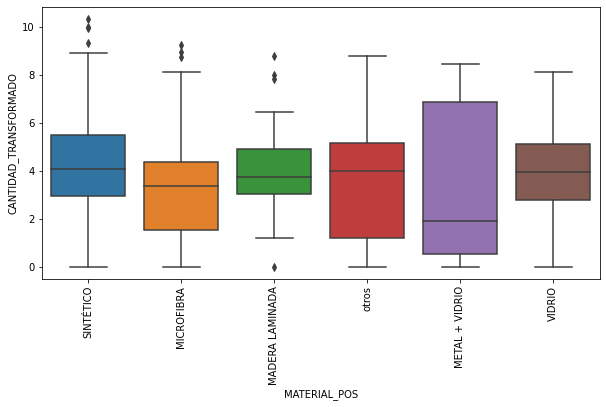

In [105]:
for i in cat_columns_plot:
    plt.figure(figsize=(10,5))
    sns.boxplot(data=references2,y='CANTIDAD_TRANSFORMADO',x=i)
    plt.xticks(rotation=90)

array([[<AxesSubplot:title={'center':'CANTIDAD_TRANSFORMADO'}>,
        <AxesSubplot:title={'center':'PRECIO_PROMEDIO_TRANSFORMADO'}>],
       [<AxesSubplot:title={'center':'ANCHO_TRANSFORMADO'}>,
        <AxesSubplot:title={'center':'ALTO_TRANSFORMADO'}>],
       [<AxesSubplot:title={'center':'FONDO_TRANSFORMADO'}>,
        <AxesSubplot:>]], dtype=object)

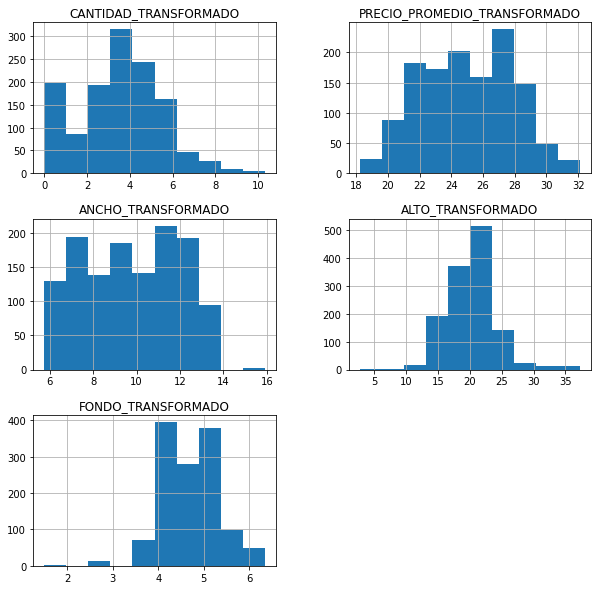

In [111]:

references2[['CANTIDAD_TRANSFORMADO','PRECIO_PROMEDIO_TRANSFORMADO','ANCHO_TRANSFORMADO','ALTO_TRANSFORMADO','FONDO_TRANSFORMADO']].hist(figsize=(10,10))

In [42]:
model2 = smf.ols(formula='CANTIDAD_TRANSFORMADO ~ PRECIO_PROMEDIO_TRANSFORMADO + ANCHO_TRANSFORMADO + ALTO_TRANSFORMADO + FONDO_TRANSFORMADO', data=references2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     CANTIDAD_TRANSFORMADO   R-squared:                       0.050
Model:                               OLS   Adj. R-squared:                  0.047
Method:                    Least Squares   F-statistic:                     16.76
Date:                   Mon, 02 Aug 2021   Prob (F-statistic):           2.14e-13
Time:                           22:07:18   Log-Likelihood:                -2668.5
No. Observations:                   1285   AIC:                             5347.
Df Residuals:                       1280   BIC:                             5373.
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        6.6430      0.568     11.691      0.000       5.528       7.758
PRECIO_PROMEDIO_TRANSFORMADO    -0.1668      0.034     -4.850      0.000      -0.234      -0.099
ANCHO_TRANSFORMADO               0.0239      0.042      0.575      0.565      -0.058       0.105
ALTO_TRANSFORMADO                0.0474      0.015      3.210      0.001       0.018       0.076
FONDO_TRANSFORMADO              -0.0332      0.131     -0.254      0.800      -0.290       0.223
==============================================================================
Omnibus:                        6.196   Durbin-Watson:                   0.102
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                4.769
Skew:                          -0.005   Prob(JB):                       0.0921
Kurtosis:                       2.702   Cond. No.                         362.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

con puestos

In [43]:
model3 = smf.ols(formula='CANTIDAD ~ PRECIO_PROMEDIO + DESCUENTO_PROMEDIO + PUESTOS + ANCHO+ ALTO+FONDO', data=references).fit()# using the seats, the na rows are ignored

In [44]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               CANTIDAD   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     16.04
Date:                Mon, 02 Aug 2021   Prob (F-statistic):           1.10e-17
Time:                        22:07:18   Log-Likelihood:                -5714.5
No. Observations:                1017   AIC:                         1.144e+04
Df Residuals:                    1010   BIC:                         1.148e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             17.4868     14.355      1.218      0.223     -10.683      45.656
PRECIO_PROMEDIO    -1.512e-05    4.7e-06     -3.219      0.001   -2.43e-05   -5.91e-06
DESCUENTO_PROMEDIO   -47.1363     16.276     -2.896      0.004     -79.076     -15.197
PUESTOS                7.0634      1.761      4.010      0.000       3.607      10.520
ANCHO                 -0.1905      0.066     -2.904      0.004      -0.319      -0.062
ALTO                   0.8866      0.144      6.149      0.000       0.604       1.170
FONDO                 -0.0546      0.078     -0.698      0.485      -0.208       0.099
==============================================================================
Omnibus:                     1024.291   Durbin-Watson:                   0.179
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            53888.992
Skew:                           4.729   Prob(JB):                         0.00
Kurtosis:                      37.384   Cond. No.                     1.13e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
references2puestos=references2.dropna()

In [46]:
lambdas=[]
for column in num_columns:
    aux=stats.boxcox(references2puestos[column])
    references2puestos["{}_TRANSFORMADO".format(column)]=aux[0]
    lambdas.append(aux[1])
    print (column,aux[1])
references2puestos['PUESTOS_TRANSFORMADO']=stats.boxcox(references2puestos['PUESTOS'])[0]

CANTIDAD 0.11808683661230637
PRECIO_PROMEDIO 0.2609377070531384
ANCHO 0.4110659683423382
ALTO 1.764755942957541
FONDO 0.09632109849313505


In [141]:
np.log(references2['CANTIDAD'])

1163    6.689599
842     6.553933
546     6.533789
1153    6.248043
650     6.202536
          ...   
299     0.000000
166     0.000000
535     0.000000
296     0.000000
117     0.000000
Name: CANTIDAD, Length: 1285, dtype: float64

In [142]:
(references2['CANTIDAD']**0.11808683661230637-1)/0.11808683661230637

1163    10.189910
842      9.893380
546      9.849753
1153     9.241960
650      9.147043
          ...    
299      0.000000
166      0.000000
535      0.000000
296      0.000000
117      0.000000
Name: CANTIDAD, Length: 1285, dtype: float64

In [137]:
references2['CANTIDAD_TRANSFORMADO']

1163    10.316107
842     10.013125
546      9.968560
1153     9.348007
650      9.251150
          ...    
299      0.000000
166      0.000000
535      0.000000
296      0.000000
117      0.000000
Name: CANTIDAD_TRANSFORMADO, Length: 1285, dtype: float64

In [47]:

model4 = smf.ols(formula='CANTIDAD_TRANSFORMADO ~ PRECIO_PROMEDIO_TRANSFORMADO + ANCHO_TRANSFORMADO + ALTO_TRANSFORMADO + FONDO_TRANSFORMADO + PUESTOS_TRANSFORMADO+ DESCUENTO_PROMEDIO', data=references2puestos).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     CANTIDAD_TRANSFORMADO   R-squared:                       0.139
Model:                               OLS   Adj. R-squared:                  0.134
Method:                    Least Squares   F-statistic:                     27.09
Date:                   Mon, 02 Aug 2021   Prob (F-statistic):           4.68e-30
Time:                           22:07:18   Log-Likelihood:                -2089.0
No. Observations:                   1017   AIC:                             4192.
Df Residuals:                       1010   BIC:                             4227.
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        8.2589      0.581     14.204      0.000       7.118       9.400
PRECIO_PROMEDIO_TRANSFORMADO    -0.0230      0.004     -5.843      0.000      -0.031      -0.015
ANCHO_TRANSFORMADO              -0.0047      0.038     -0.125      0.901      -0.079       0.069
ALTO_TRANSFORMADO                0.0008      0.000      5.479      0.000       0.001       0.001
FONDO_TRANSFORMADO              -0.5823      0.135     -4.301      0.000      -0.848      -0.317
PUESTOS_TRANSFORMADO             1.1346      0.200      5.673      0.000       0.742       1.527
DESCUENTO_PROMEDIO              -0.6612      0.462     -1.432      0.152      -1.567       0.245
==============================================================================
Omnibus:                        9.511   Durbin-Watson:                   0.276
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                6.830
Skew:                          -0.069   Prob(JB):                       0.0329
Kurtosis:                       2.623   Cond. No.                     1.56e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
model42 = smf.ols(formula='CANTIDAD_TRANSFORMADO ~ PRECIO_PROMEDIO_TRANSFORMADO + np.log(ANCHO_TRANSFORMADO * ALTO_TRANSFORMADO *FONDO_TRANSFORMADO) + PUESTOS_TRANSFORMADO+ DESCUENTO_PROMEDIO', data=references2puestos).fit()
model42.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     CANTIDAD_TRANSFORMADO   R-squared:                       0.093
Model:                               OLS   Adj. R-squared:                  0.090
Method:                    Least Squares   F-statistic:                     26.00
Date:                   Mon, 02 Aug 2021   Prob (F-statistic):           1.54e-20
Time:                           22:07:18   Log-Likelihood:                -2115.2
No. Observations:                   1017   AIC:                             4240.
Df Residuals:                       1012   BIC:                             4265.
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
=======================================================================================================================================
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                               4.3518      1.282      3.396      0.001       1.837       6.867
PRECIO_PROMEDIO_TRANSFORMADO                                           -0.0307      0.003     -9.187      0.000      -0.037      -0.024
np.log(ANCHO_TRANSFORMADO * ALTO_TRANSFORMADO * FONDO_TRANSFORMADO)     0.2513      0.129      1.951      0.051      -0.001       0.504
PUESTOS_TRANSFORMADO                                                    0.7784      0.162      4.793      0.000       0.460       1.097
DESCUENTO_PROMEDIO                                                     -0.3493      0.470     -0.744      0.457      -1.271       0.572
==============================================================================
Omnibus:                        6.325   Durbin-Watson:                   0.186
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                4.876
Skew:                          -0.052   Prob(JB):                       0.0873
Kurtosis:                       2.677   Cond. No.                     2.80e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
model5 = smf.ols(formula='CANTIDAD_TRANSFORMADO ~ PRECIO_PROMEDIO_TRANSFORMADO + ANCHO_TRANSFORMADO + ALTO_TRANSFORMADO + FONDO_TRANSFORMADO+ PUESTOS+ DESCUENTO_PROMEDIO', data=references2).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     CANTIDAD_TRANSFORMADO   R-squared:                       0.119
Model:                               OLS   Adj. R-squared:                  0.114
Method:                    Least Squares   F-statistic:                     22.70
Date:                   Mon, 02 Aug 2021   Prob (F-statistic):           3.35e-25
Time:                           22:07:18   Log-Likelihood:                -2110.0
No. Observations:                   1017   AIC:                             4234.
Df Residuals:                       1010   BIC:                             4268.
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       10.1221      0.816     12.404      0.000       8.521      11.723
PRECIO_PROMEDIO_TRANSFORMADO    -0.2577      0.042     -6.162      0.000      -0.340      -0.176
ANCHO_TRANSFORMADO               0.1524      0.059      2.590      0.010       0.037       0.268
ALTO_TRANSFORMADO                0.0995      0.024      4.194      0.000       0.053       0.146
FONDO_TRANSFORMADO              -0.7655      0.166     -4.607      0.000      -1.092      -0.439
PUESTOS                          0.1804      0.051      3.510      0.000       0.080       0.281
DESCUENTO_PROMEDIO              -0.5758      0.471     -1.223      0.222      -1.500       0.348
==============================================================================
Omnibus:                       10.508   Durbin-Watson:                   0.238
Prob(Omnibus):                  0.005   Jarque-Bera (JB):                6.979
Skew:                          -0.014   Prob(JB):                       0.0305
Kurtosis:                       2.595   Cond. No.                         480.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ahora jugar con las categoricas

In [50]:
pd.set_option('display.max_columns', None)
references2.head(1)

REF  CANTIDAD      TOTAL  PRECIO_PROMEDIO  DESCUENTO_PROMEDIO  \
1163  XZ0564:00005:       804  107971047     229995.85724            0.380553   

      ITEM         DESCRIPCION  CATEGORIA       SUBCATEGORIA VIGENCIA  \
1163  1436  SILLA COMEDOR JAIM  COMEDORES  SILLAS DE COMEDOR    LINEA   

         ORIGEN   ESTILO   MATERIAL            ACABADO  PUESTOS  COLOR  ANCHO  \
1163  IMPORTADO  MODERNO  SINTÉTICO  SUPERFICIES MATES      1.0  NEGRO   41.0   

       ALTO  FONDO                        DESC_LARGA   SUBCATEGORIA_POS  \
1163  104.0   58.0  SILLA COMEDOR JAIM CROMADO NG 2C  SILLAS DE COMEDOR   

     COLOR_POS MATERIAL_POS  CANTIDAD_TRANSFORMADO  \
1163     NEGRO    SINTÉTICO              10.316107   

      PRECIO_PROMEDIO_TRANSFORMADO  ANCHO_TRANSFORMADO  ALTO_TRANSFORMADO  \
1163                     22.097309            6.722158          24.166917   

      FONDO_TRANSFORMADO  
1163            4.510294

In [51]:
references2['SUBCATEGORIA_POS'].unique()

array(['SILLAS DE COMEDOR', 'OTROS', 'RECLINABLES', 'SET 4P',
       'SILLAS AUXILIARES', 'SET 6P', 'RECLINABLES 1P',
       'SOFA CAMA ABATIBLE', 'POLTRONAS', 'MESAS DE 4P',
       'MESAS DE CENTRO', 'PUFF', 'SOFA 3P', 'SOFA 2P'], dtype=object)

In [102]:
model6 = smf.ols(formula='CANTIDAD_TRANSFORMADO ~ C(CATEGORIA)+C(SUBCATEGORIA_POS)+C(VIGENCIA)+C(ORIGEN)+C(ESTILO)+C(MATERIAL_POS)+C(ACABADO)+C(COLOR_POS) ', data=references2).fit()
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     CANTIDAD_TRANSFORMADO   R-squared:                       0.446
Model:                               OLS   Adj. R-squared:                  0.425
Method:                    Least Squares   F-statistic:                     21.67
Date:                   Mon, 02 Aug 2021   Prob (F-statistic):          1.20e-126
Time:                           22:31:14   Log-Likelihood:                -2321.8
No. Observations:                   1285   AIC:                             4738.
Df Residuals:                       1238   BIC:                             4980.
Df Model:                             46                                         
Covariance Type:               nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    10.1715      0.794     12.813      0.000       8.614      11.729
C(CATEGORIA)[T.COMEDORES]                    -0.2578      0.296     -0.872      0.383      -0.838       0.322
C(CATEGORIA)[T.ESTUDIO]                      -0.2838      0.314     -0.903      0.367      -0.901       0.333
C(CATEGORIA)[T.SALAS Y SOFAS]                -0.9476      0.238     -3.973      0.000      -1.415      -0.480
C(SUBCATEGORIA_POS)[T.MESAS DE CENTRO]        0.5844      0.401      1.458      0.145      -0.202       1.371
C(SUBCATEGORIA_POS)[T.OTROS]                 -0.2246      0.342     -0.656      0.512      -0.896       0.447
C(SUBCATEGORIA_POS)[T.POLTRONAS]              0.0872      0.418      0.209      0.835      -0.733       0.908
C(SUBCATEGORIA_POS)[T.PUFF]                   1.1433      0.454      2.517      0.012       0.252       2.035
C(SUBCATEGORIA_POS)[T.RECLINABLES]            2.2762      0.467      4.878      0.000       1.361       3.192
C(SUBCATEGORIA_POS)[T.RECLINABLES 1P]         2.2659      0.488      4.646      0.000       1.309       3.223
C(SUBCATEGORIA_POS)[T.SET 4P]                 0.5024      0.358      1.402      0.161      -0.201       1.206
C(SUBCATEGORIA_POS)[T.SET 6P]                 0.0810      0.391      0.207      0.836      -0.687       0.849
C(SUBCATEGORIA_POS)[T.SILLAS AUXILIARES]      0.4042      0.404      1.001      0.317      -0.388       1.197
C(SUBCATEGORIA_POS)[T.SILLAS DE COMEDOR]      1.2247      0.399      3.067      0.002       0.441       2.008
C(SUBCATEGORIA_POS)[T.SOFA 2P]                1.7654      0.402      4.396      0.000       0.977       2.553
C(SUBCATEGORIA_POS)[T.SOFA 3P]                2.0635      0.408      5.057      0.000       1.263       2.864
C(SUBCATEGORIA_POS)[T.SOFA CAMA ABATIBLE]     2.6366      0.454      5.809      0.000       1.746       3.527
C(VIGENCIA)[T.LINEA]                          0.5475      0.116      4.740      0.000       0.321       0.774
C(VIGENCIA)[T.NOVEDAD]                        0.1250      0.131      0.951      0.342      -0.133       0.383
C(ORIGEN)[T.MANUFACTURADO]                   -1.4553      0.168     -8.658      0.000      -1.785      -1.126
C(ORIGEN)[T.NACIONAL]                        -0.9987      0.323     -3.092      0.002      -1.633      -0.365
C(ESTILO)[T.CLÁSICO]                          1.0553      0.264      3.994      0.000       0.537       1.574
C(ESTILO)[T.CONTEMPORÁNEO]                    1.1799      0.255      4.633      0.000       0.680       1.680
C(ESTILO)[T.MODERNO]                          0.8313      0.247      3.369      0.001       0.347       1.315
C(MATERIAL_POS)[T.METAL + VIDRIO]            -3.9159      0.425     -9.216      

con todo pero sin variable puestos

In [155]:
model7 = smf.ols(formula='CANTIDAD_TRANSFORMADO ~ C(CATEGORIA)+C(SUBCATEGORIA_POS)+C(VIGENCIA)+C(ORIGEN)+C(ESTILO)+C(MATERIAL_POS)+C(ACABADO)+C(COLOR_POS)+PRECIO_PROMEDIO_TRANSFORMADO + ANCHO_TRANSFORMADO + ALTO_TRANSFORMADO + FONDO_TRANSFORMADO+ DESCUENTO_PROMEDIO ', data=references2).fit()
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     CANTIDAD_TRANSFORMADO   R-squared:                       0.460
Model:                               OLS   Adj. R-squared:                  0.438
Method:                    Least Squares   F-statistic:                     20.60
Date:                   Wed, 04 Aug 2021   Prob (F-statistic):          7.21e-130
Time:                           00:35:21   Log-Likelihood:                -2305.4
No. Observations:                   1285   AIC:                             4715.
Df Residuals:                       1233   BIC:                             4983.
Df Model:                             51                                         
Covariance Type:               nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     9.6659      1.063      9.093      0.000       7.580      11.751
C(CATEGORIA)[T.COMEDORES]                    -0.4139      0.305     -1.359      0.174      -1.012       0.184
C(CATEGORIA)[T.ESTUDIO]                      -0.5780      0.331     -1.747      0.081      -1.227       0.071
C(CATEGORIA)[T.SALAS Y SOFAS]                -0.9949      0.250     -3.979      0.000      -1.485      -0.504
C(SUBCATEGORIA_POS)[T.MESAS DE CENTRO]        0.8388      0.408      2.058      0.040       0.039       1.638
C(SUBCATEGORIA_POS)[T.OTROS]                 -0.0636      0.344     -0.185      0.853      -0.738       0.611
C(SUBCATEGORIA_POS)[T.POLTRONAS]              0.6018      0.457      1.317      0.188      -0.295       1.498
C(SUBCATEGORIA_POS)[T.PUFF]                   1.9029      0.525      3.622      0.000       0.872       2.934
C(SUBCATEGORIA_POS)[T.RECLINABLES]            2.4524      0.469      5.232      0.000       1.533       3.372
C(SUBCATEGORIA_POS)[T.RECLINABLES 1P]         2.5194      0.501      5.030      0.000       1.537       3.502
C(SUBCATEGORIA_POS)[T.SET 4P]                 0.6738      0.361      1.866      0.062      -0.035       1.382
C(SUBCATEGORIA_POS)[T.SET 6P]                 0.1768      0.397      0.446      0.656      -0.602       0.955
C(SUBCATEGORIA_POS)[T.SILLAS AUXILIARES]      0.8425      0.435      1.937      0.053      -0.011       1.696
C(SUBCATEGORIA_POS)[T.SILLAS DE COMEDOR]      1.7750      0.450      3.948      0.000       0.893       2.657
C(SUBCATEGORIA_POS)[T.SOFA 2P]                2.1905      0.412      5.314      0.000       1.382       2.999
C(SUBCATEGORIA_POS)[T.SOFA 3P]                2.3905      0.416      5.753      0.000       1.575       3.206
C(SUBCATEGORIA_POS)[T.SOFA CAMA ABATIBLE]     2.7649      0.456      6.058      0.000       1.870       3.660
C(VIGENCIA)[T.LINEA]                          0.4971      0.116      4.279      0.000       0.269       0.725
C(VIGENCIA)[T.NOVEDAD]                        0.0701      0.135      0.518      0.605      -0.195       0.336
C(ORIGEN)[T.MANUFACTURADO]                   -1.5329      0.172     -8.912      0.000      -1.870      -1.195
C(ORIGEN)[T.NACIONAL]                        -1.1659      0.338     -3.449      0.001      -1.829      -0.503
C(ESTILO)[T.CLÁSICO]                          0.9981      0.264      3.786      0.000       0.481       1.515
C(ESTILO)[T.CONTEMPORÁNEO]                    1.1535      0.258      4.470      0.000       0.647       1.660
C(ESTILO)[T.MODERNO]                          0.8060      0.250      3.230      0.001       0.317       1.296
C(MATERIAL_POS)[T.METAL + VIDRIO]            -3.7404      0.422     -8.864      

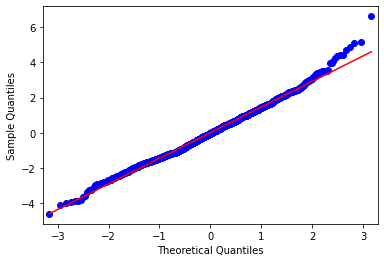

In [133]:
sm.qqplot(model7.resid, line="s");

<AxesSubplot:xlabel='FONDO_TRANSFORMADO'>

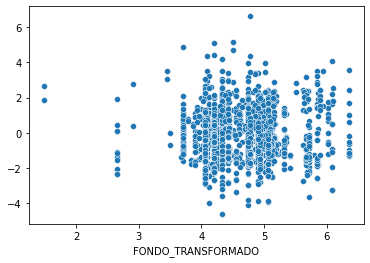

In [146]:
sns.scatterplot(references2['FONDO_TRANSFORMADO'],model7.resid)

un poco de heteroscedasticity, pero no mucha

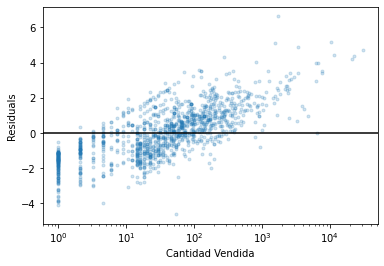

In [144]:
plt.semilogx(np.exp(references2["CANTIDAD_TRANSFORMADO"]), model7.resid, ".", alpha=0.2)
plt.ylabel("Residuals")
plt.xlabel("Cantidad Vendida")
plt.axhline(0, color="black")

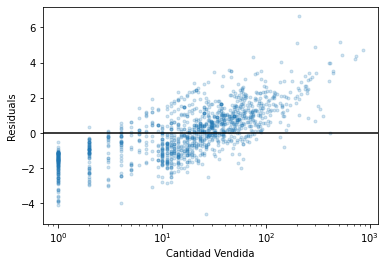

In [143]:
plt.semilogx((references2["CANTIDAD_TRANSFORMADO"]*0.11808683661230637+1)**(1/0.11808683661230637), model7.resid, ".", alpha=0.2)
plt.ylabel("Residuals")
plt.xlabel("Cantidad Vendida")
plt.axhline(0, color="black")

In [147]:
references2['residuals']=model7.resid

In [153]:
outliers = np.abs(model7.resid) < 1.5
data_noout = references2.loc[outliers, :]
# refit a model with the reduced data
model_noout = smf.ols(formula='CANTIDAD_TRANSFORMADO ~ C(CATEGORIA)+C(SUBCATEGORIA_POS)+C(VIGENCIA)+C(ORIGEN)+C(ESTILO)+C(MATERIAL_POS)+C(ACABADO)+C(COLOR_POS)+PRECIO_PROMEDIO_TRANSFORMADO + ANCHO_TRANSFORMADO + ALTO_TRANSFORMADO + FONDO_TRANSFORMADO+ DESCUENTO_PROMEDIO ', data=data_noout).fit()
# inspect the `Units` coefficient
print("{:.2f}% of data removed".format((1-data_noout.size/references2.size)*100))
print("`FONDO TRANSFORMADO` coefficient in full model:          {:.3f}".format(model7.params["FONDO_TRANSFORMADO"]))
print("`FONDO TRANSFORMADO` coefficient with excluded outliers: {:.3f}".format(model_noout.params["FONDO_TRANSFORMADO"]))

29.65% of data removed
`FONDO TRANSFORMADO` coefficient in full model:          0.317
`FONDO TRANSFORMADO` coefficient with excluded outliers: 0.264


In [154]:
model_noout.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     CANTIDAD_TRANSFORMADO   R-squared:                       0.770
Model:                               OLS   Adj. R-squared:                  0.756
Method:                    Least Squares   F-statistic:                     55.90
Date:                   Wed, 04 Aug 2021   Prob (F-statistic):          4.41e-235
Time:                           00:30:30   Log-Likelihood:                -1068.6
No. Observations:                    904   AIC:                             2241.
Df Residuals:                        852   BIC:                             2491.
Df Model:                             51                                         
Covariance Type:               nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    12.5227      0.738     16.960      0.000      11.073      13.972
C(CATEGORIA)[T.COMEDORES]                    -0.2338      0.200     -1.171      0.242      -0.626       0.158
C(CATEGORIA)[T.ESTUDIO]                      -0.6151      0.209     -2.943      0.003      -1.025      -0.205
C(CATEGORIA)[T.SALAS Y SOFAS]                -0.9360      0.175     -5.334      0.000      -1.280      -0.592
C(SUBCATEGORIA_POS)[T.MESAS DE CENTRO]        0.3264      0.289      1.129      0.259      -0.241       0.894
C(SUBCATEGORIA_POS)[T.OTROS]                 -0.4074      0.251     -1.625      0.104      -0.899       0.085
C(SUBCATEGORIA_POS)[T.POLTRONAS]              0.5432      0.322      1.689      0.092      -0.088       1.175
C(SUBCATEGORIA_POS)[T.PUFF]                   1.0826      0.358      3.023      0.003       0.380       1.786
C(SUBCATEGORIA_POS)[T.RECLINABLES]            1.8137      0.330      5.496      0.000       1.166       2.461
C(SUBCATEGORIA_POS)[T.RECLINABLES 1P]         1.8679      0.346      5.403      0.000       1.189       2.546
C(SUBCATEGORIA_POS)[T.SET 4P]                 0.4244      0.258      1.642      0.101      -0.083       0.932
C(SUBCATEGORIA_POS)[T.SET 6P]                 0.1363      0.280      0.487      0.627      -0.413       0.686
C(SUBCATEGORIA_POS)[T.SILLAS AUXILIARES]      0.3057      0.309      0.990      0.322      -0.300       0.912
C(SUBCATEGORIA_POS)[T.SILLAS DE COMEDOR]      1.0577      0.318      3.323      0.001       0.433       1.682
C(SUBCATEGORIA_POS)[T.SOFA 2P]                2.1703      0.290      7.476      0.000       1.601       2.740
C(SUBCATEGORIA_POS)[T.SOFA 3P]                2.3677      0.292      8.097      0.000       1.794       2.942
C(SUBCATEGORIA_POS)[T.SOFA CAMA ABATIBLE]     2.5570      0.328      7.806      0.000       1.914       3.200
C(VIGENCIA)[T.LINEA]                          0.5886      0.079      7.420      0.000       0.433       0.744
C(VIGENCIA)[T.NOVEDAD]                        0.2226      0.092      2.422      0.016       0.042       0.403
C(ORIGEN)[T.MANUFACTURADO]                   -1.9093      0.117    -16.300      0.000      -2.139      -1.679
C(ORIGEN)[T.NACIONAL]                        -1.2194      0.229     -5.330      0.000      -1.668      -0.770
C(ESTILO)[T.CLÁSICO]                          1.0864      0.182      5.954      0.000       0.728       1.444
C(ESTILO)[T.CONTEMPORÁNEO]                    0.9508      0.184      5.171      0.000       0.590       1.312
C(ESTILO)[T.MODERNO]                          0.6737      0.180      3.732      0.000       0.319       1.028
C(MATERIAL_POS)[T.METAL + VIDRIO]            -4.1928      0.261    -16.038      

para puestos sin transformar

In [54]:
model7 = smf.ols(formula='CANTIDAD_TRANSFORMADO ~ C(CATEGORIA)+C(SUBCATEGORIA_POS)+C(VIGENCIA)+C(ORIGEN)+C(ESTILO)+C(MATERIAL_POS)+C(ACABADO)+C(COLOR_POS)+PRECIO_PROMEDIO_TRANSFORMADO + ANCHO_TRANSFORMADO + ALTO_TRANSFORMADO + FONDO_TRANSFORMADO+ DESCUENTO_PROMEDIO+ PUESTOS ', data=references2).fit()
model7.summary() #recordar que esta implementacion dropea los rows none automatico.

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     CANTIDAD_TRANSFORMADO   R-squared:                       0.527
Model:                               OLS   Adj. R-squared:                  0.502
Method:                    Least Squares   F-statistic:                     21.10
Date:                   Mon, 02 Aug 2021   Prob (F-statistic):          5.73e-123
Time:                           22:07:19   Log-Likelihood:                -1793.4
No. Observations:                   1017   AIC:                             3691.
Df Residuals:                        965   BIC:                             3947.
Df Model:                             51                                         
Covariance Type:               nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    16.8677      1.658     10.172      0.000      13.614      20.122
C(CATEGORIA)[T.COMEDORES]                    -1.7939      0.453     -3.963      0.000      -2.682      -0.906
C(CATEGORIA)[T.ESTUDIO]                      -2.3181      0.601     -3.854      0.000      -3.498      -1.138
C(CATEGORIA)[T.SALAS Y SOFAS]                -2.2070      0.417     -5.291      0.000      -3.026      -1.389
C(SUBCATEGORIA_POS)[T.MESAS DE CENTRO]    -1.109e-13   2.08e-14     -5.338      0.000   -1.52e-13   -7.01e-14
C(SUBCATEGORIA_POS)[T.OTROS]                  0.2001      0.397      0.504      0.615      -0.579       0.980
C(SUBCATEGORIA_POS)[T.POLTRONAS]              0.1083      0.542      0.200      0.842      -0.955       1.172
C(SUBCATEGORIA_POS)[T.PUFF]                   0.9063      0.685      1.324      0.186      -0.437       2.250
C(SUBCATEGORIA_POS)[T.RECLINABLES]            2.2539      0.520      4.338      0.000       1.234       3.273
C(SUBCATEGORIA_POS)[T.RECLINABLES 1P]         2.6791      0.548      4.888      0.000       1.603       3.755
C(SUBCATEGORIA_POS)[T.SET 4P]                 0.7570      0.362      2.092      0.037       0.047       1.467
C(SUBCATEGORIA_POS)[T.SET 6P]                 0.1743      0.415      0.420      0.675      -0.641       0.989
C(SUBCATEGORIA_POS)[T.SILLAS AUXILIARES]      0.6313      0.507      1.246      0.213      -0.363       1.626
C(SUBCATEGORIA_POS)[T.SILLAS DE COMEDOR]      1.3486      0.497      2.715      0.007       0.374       2.323
C(SUBCATEGORIA_POS)[T.SOFA 2P]                2.2283      0.453      4.924      0.000       1.340       3.116
C(SUBCATEGORIA_POS)[T.SOFA 3P]                2.4081      0.456      5.278      0.000       1.513       3.304
C(SUBCATEGORIA_POS)[T.SOFA CAMA ABATIBLE]     2.9094      0.497      5.859      0.000       1.935       3.884
C(VIGENCIA)[T.LINEA]                          0.6614      0.126      5.241      0.000       0.414       0.909
C(VIGENCIA)[T.NOVEDAD]                        0.2059      0.152      1.358      0.175      -0.092       0.503
C(ORIGEN)[T.MANUFACTURADO]                   -1.1916      0.180     -6.603      0.000      -1.546      -0.837
C(ORIGEN)[T.NACIONAL]                        -1.1427      0.463     -2.468      0.014      -2.051      -0.234
C(ESTILO)[T.CLÁSICO]                          0.2641      0.343      0.769      0.442      -0.410       0.938
C(ESTILO)[T.CONTEMPORÁNEO]                    0.1524      0.361      0.422      0.673      -0.557       0.862
C(ESTILO)[T.MODERNO]                         -0.4648      0.355     -1.309      0.191      -1.161       0.232
C(MATERIAL_POS)[T.METAL + VIDRIO]            -4.6179      0.484     -9.544      

para puestos transformados

In [128]:
model8 = smf.ols(formula='CANTIDAD_TRANSFORMADO ~ PRECIO_PROMEDIO_TRANSFORMADO + ANCHO_TRANSFORMADO + ALTO_TRANSFORMADO + FONDO_TRANSFORMADO + PUESTOS_TRANSFORMADO+ DESCUENTO_PROMEDIO+ C(CATEGORIA)+C(SUBCATEGORIA_POS)+C(VIGENCIA)+C(ORIGEN)+C(ESTILO)+C(MATERIAL_POS)+C(ACABADO)+C(COLOR_POS)', data=references2puestos).fit()
model8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     CANTIDAD_TRANSFORMADO   R-squared:                       0.532
Model:                               OLS   Adj. R-squared:                  0.507
Method:                    Least Squares   F-statistic:                     21.47
Date:                   Wed, 04 Aug 2021   Prob (F-statistic):          8.64e-125
Time:                           00:09:16   Log-Likelihood:                -1779.3
No. Observations:                   1017   AIC:                             3663.
Df Residuals:                        965   BIC:                             3919.
Df Model:                             51                                         
Covariance Type:               nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    14.7373      1.314     11.217      0.000      12.159      17.316
C(CATEGORIA)[T.COMEDORES]                    -1.9107      0.436     -4.383      0.000      -2.766      -1.055
C(CATEGORIA)[T.ESTUDIO]                      -2.0503      0.584     -3.510      0.000      -3.197      -0.904
C(CATEGORIA)[T.SALAS Y SOFAS]                -2.4529      0.419     -5.853      0.000      -3.275      -1.630
C(SUBCATEGORIA_POS)[T.OTROS]                  0.2730      0.390      0.700      0.484      -0.492       1.038
C(SUBCATEGORIA_POS)[T.POLTRONAS]              0.7898      0.575      1.374      0.170      -0.338       1.918
C(SUBCATEGORIA_POS)[T.PUFF]                   1.6113      0.663      2.431      0.015       0.311       2.912
C(SUBCATEGORIA_POS)[T.RECLINABLES]            2.3183      0.518      4.473      0.000       1.301       3.335
C(SUBCATEGORIA_POS)[T.RECLINABLES 1P]         3.3038      0.603      5.480      0.000       2.121       4.487
C(SUBCATEGORIA_POS)[T.SET 4P]                 0.7318      0.356      2.058      0.040       0.034       1.430
C(SUBCATEGORIA_POS)[T.SET 6P]                 0.2632      0.396      0.664      0.507      -0.514       1.041
C(SUBCATEGORIA_POS)[T.SILLAS AUXILIARES]      1.3198      0.541      2.440      0.015       0.259       2.381
C(SUBCATEGORIA_POS)[T.SILLAS DE COMEDOR]      1.8326      0.512      3.576      0.000       0.827       2.838
C(SUBCATEGORIA_POS)[T.SOFA 2P]                2.4548      0.457      5.373      0.000       1.558       3.351
C(SUBCATEGORIA_POS)[T.SOFA 3P]                2.4500      0.449      5.453      0.000       1.568       3.332
C(SUBCATEGORIA_POS)[T.SOFA CAMA ABATIBLE]     2.8829      0.487      5.923      0.000       1.928       3.838
C(VIGENCIA)[T.LINEA]                          0.6385      0.124      5.139      0.000       0.395       0.882
C(VIGENCIA)[T.NOVEDAD]                        0.1721      0.148      1.160      0.246      -0.119       0.463
C(ORIGEN)[T.MANUFACTURADO]                   -1.2416      0.178     -6.985      0.000      -1.590      -0.893
C(ORIGEN)[T.NACIONAL]                        -0.9705      0.459     -2.114      0.035      -1.872      -0.070
C(ESTILO)[T.CLÁSICO]                          0.3213      0.339      0.948      0.343      -0.343       0.986
C(ESTILO)[T.CONTEMPORÁNEO]                    0.1684      0.357      0.472      0.637      -0.532       0.868
C(ESTILO)[T.MODERNO]                         -0.4248      0.350     -1.212      0.226      -1.112       0.263
C(MATERIAL_POS)[T.METAL + VIDRIO]            -4.6005      0.478     -9.623      0.000      -5.539      -3.662
C(MATERIAL_POS)[T.MICROFIBRA]                -1.1057      0.480     -2.302      

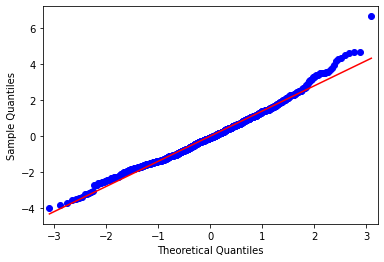

In [129]:
sm.qqplot(model8.resid, line="s");

## Pre Clustering

In [56]:
references.head(1)

REF  CANTIDAD      TOTAL  PRECIO_PROMEDIO  DESCUENTO_PROMEDIO  \
1163  XZ0564:00005:       804  107971047     229995.85724            0.380553   

      ITEM         DESCRIPCION  CATEGORIA       SUBCATEGORIA VIGENCIA  \
1163  1436  SILLA COMEDOR JAIM  COMEDORES  SILLAS DE COMEDOR    LINEA   

         ORIGEN   ESTILO   MATERIAL            ACABADO  PUESTOS  COLOR  ANCHO  \
1163  IMPORTADO  MODERNO  SINTÉTICO  SUPERFICIES MATES      1.0  NEGRO   41.0   

       ALTO  FONDO                        DESC_LARGA   SUBCATEGORIA_POS  \
1163  104.0   58.0  SILLA COMEDOR JAIM CROMADO NG 2C  SILLAS DE COMEDOR   

     COLOR_POS MATERIAL_POS  
1163     NEGRO    SINTÉTICO

In [57]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
references3=references.copy()
references3[['CANTIDAD','TOTAL','PRECIO_PROMEDIO','DESCUENTO_PROMEDIO','ANCHO','ALTO','FONDO']] = scaler.fit_transform(references3[['CANTIDAD','TOTAL','PRECIO_PROMEDIO','DESCUENTO_PROMEDIO','ANCHO','ALTO','FONDO']])

Text(0.5, 0, 'PRECIO PROMEDIO')

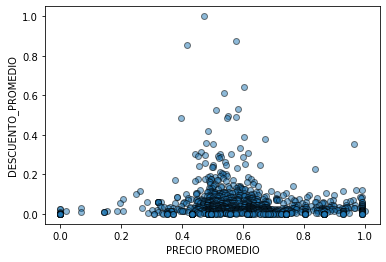

In [58]:
plt.scatter(references3['DESCUENTO_PROMEDIO'], references3['CANTIDAD'], edgecolor='k', alpha=0.5)
plt.ylabel('DESCUENTO_PROMEDIO')
plt.xlabel('PRECIO PROMEDIO')

# Clustering

In [59]:
from sklearn.cluster import KMeans

In [60]:
cols=['PRECIO_PROMEDIO','DESCUENTO_PROMEDIO','ANCHO','ALTO','FONDO']
k = 4

kmeans = KMeans(n_clusters=k, init='k-means++')
kmeans.fit(references3[cols])

# Iterative procedure to learn labels  
labels = kmeans.predict(references3[cols])
centroids = kmeans.cluster_centers_



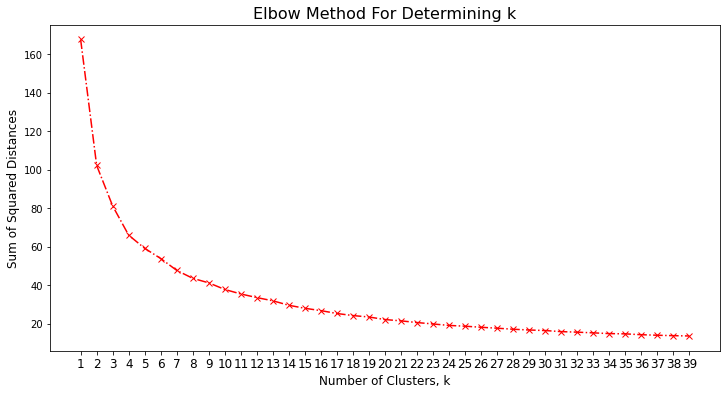

In [61]:
sum_sq_d = []
K = range(1,40)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(references3[cols])
    sum_sq_d.append(km.inertia_)
    
plt.figure(figsize=(12,6))

plt.plot(K, sum_sq_d, 'rx-.')

plt.xlabel('Number of Clusters, k', fontsize=12)
plt.xticks(range(1,40), fontsize=12)

plt.ylabel('Sum of Squared Distances', fontsize=12)
plt.xticks(fontsize=12)

plt.title('Elbow Method For Determining k', fontsize=16)

plt.show()

therefore up to 20 clusters the analysis will be enough

## 4. Vigencia y Categoria

<AxesSubplot:xlabel='VIGENCIA', ylabel='SUBCATEGORIA_POS'>

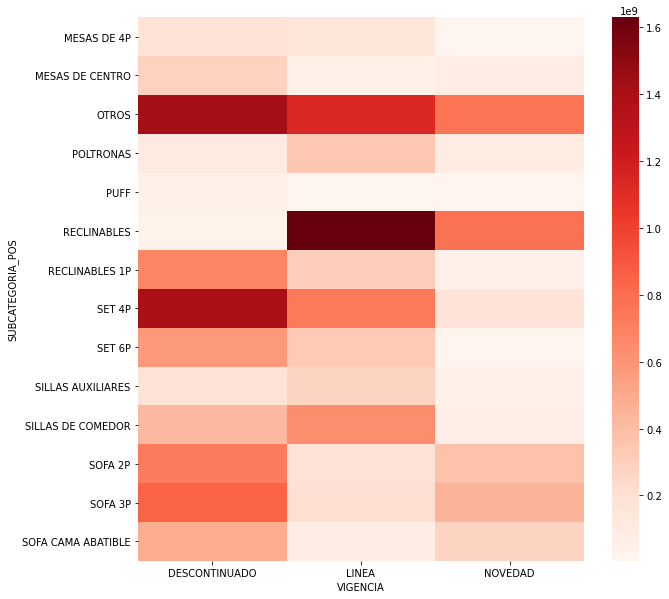

In [62]:
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(pd.pivot_table(data=references,index='SUBCATEGORIA_POS',columns='VIGENCIA',values='TOTAL',aggfunc='sum'),cmap='Reds', robust=True)

## Estilo y Categoria

<AxesSubplot:xlabel='ESTILO', ylabel='SUBCATEGORIA_POS'>

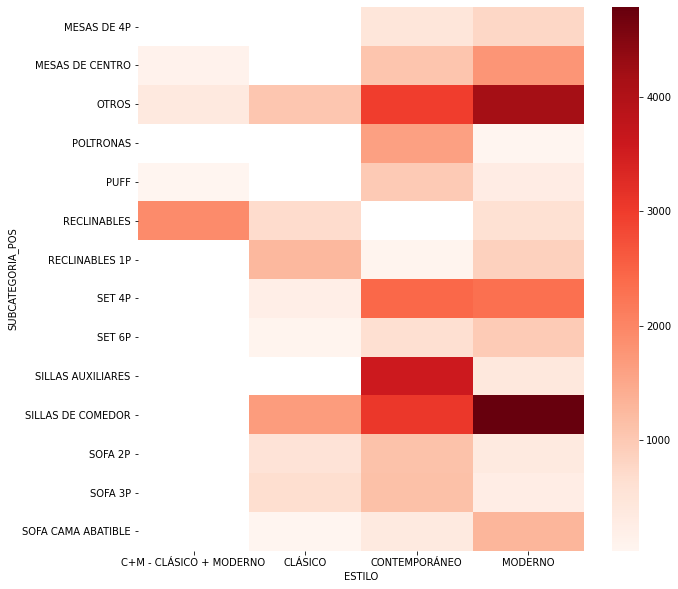

In [63]:
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(pd.pivot_table(data=references,index='SUBCATEGORIA_POS',columns='ESTILO',values='CANTIDAD',aggfunc='sum'),cmap='Reds',robust=True)

## Material Principal y Categoria

<AxesSubplot:xlabel='MATERIAL_POS', ylabel='SUBCATEGORIA_POS'>

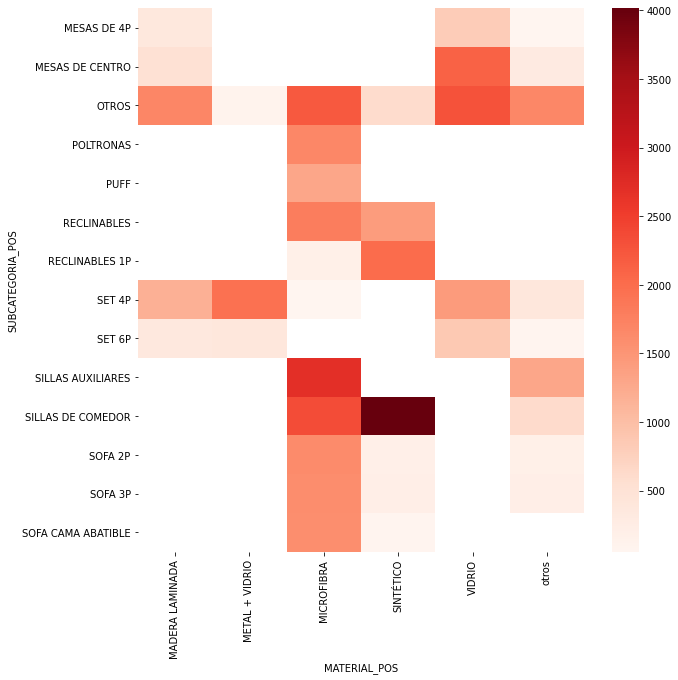

In [64]:
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(pd.pivot_table(data=references,index='SUBCATEGORIA_POS',columns='MATERIAL_POS',values='CANTIDAD',aggfunc='sum'),cmap='Reds', robust=True)

## Acabado y SUBCATEGORIA_POS

<AxesSubplot:xlabel='ACABADO', ylabel='SUBCATEGORIA_POS'>

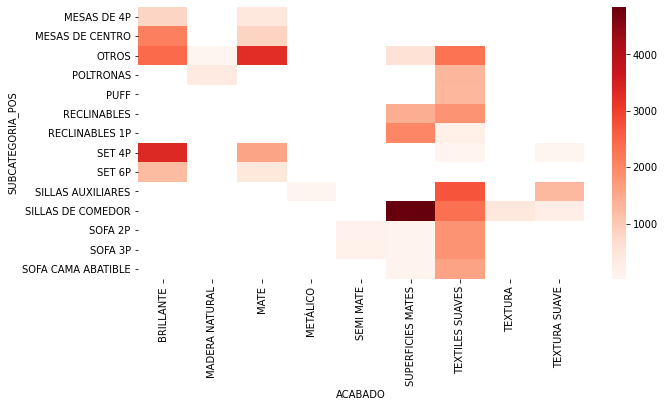

In [65]:
fig,ax=plt.subplots(figsize=(10,5))
sns.heatmap(pd.pivot_table(data=references,index='SUBCATEGORIA_POS',columns='ACABADO',values='CANTIDAD',aggfunc='sum'),cmap='Reds', robust=True)

## Numero Puestos y SUBCATEGORIA_POS

<AxesSubplot:xlabel='PUESTOS', ylabel='SUBCATEGORIA_POS'>

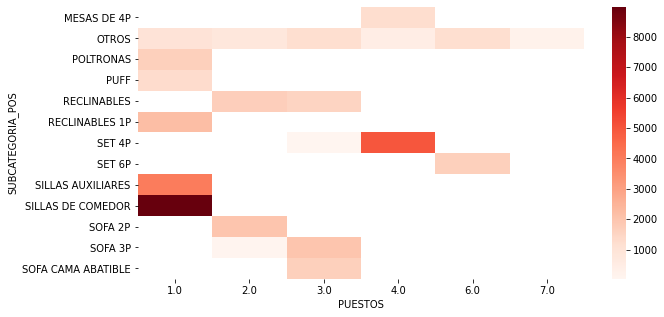

In [66]:
fig,ax=plt.subplots(figsize=(10,5))
sns.heatmap(pd.pivot_table(data=references,index='SUBCATEGORIA_POS',columns='PUESTOS',values='CANTIDAD',aggfunc='sum'),cmap='Reds', robust=True)

### 3. Sales by Color

Text(0.5, 1.0, 'Sales by Main Color\n')

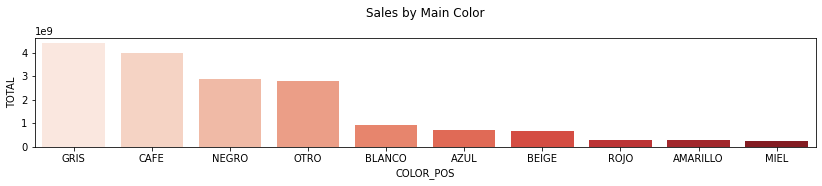

In [67]:
color = sales_prod.groupby('COLOR_POS')['TOTAL'].sum().sort_values(ascending=False).to_frame().reset_index().head(10)
fig, axes = plt.subplots(1, 1,figsize=(14,2))
sns.barplot(data=color, x='COLOR_POS', y='TOTAL', palette="Reds")
plt.title('Sales by Main Color\n')

## 6. Sales by Material Ppal vs Subcategory

<AxesSubplot:title={'center':'Sales by Material Ppal vs Subcategory\n'}, xlabel='MATERIAL_POS', ylabel='SUBCATEGORIA_POS'>

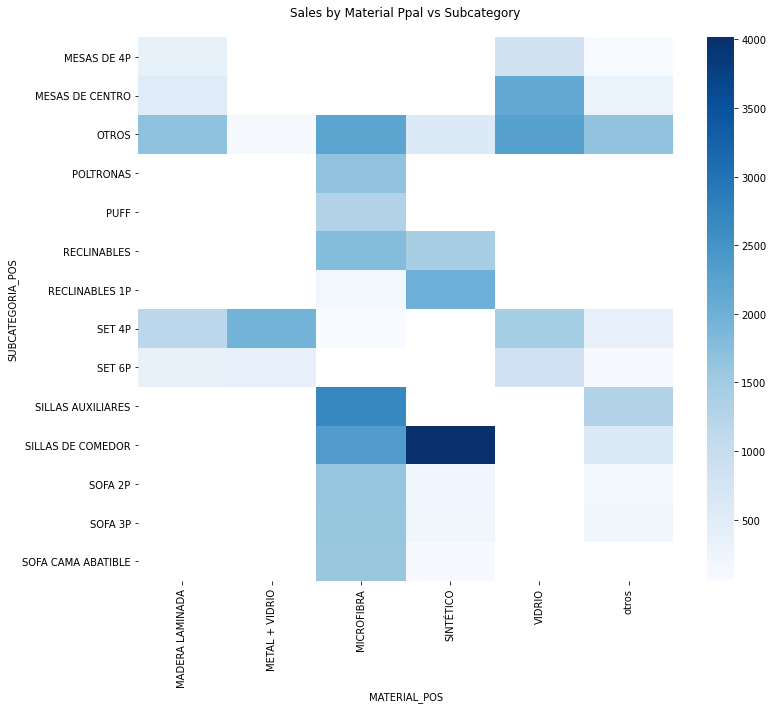

In [68]:
fig,ax=plt.subplots(figsize=(12,10))
plt.title('Sales by Material Ppal vs Subcategory\n')
sns.heatmap(pd.pivot_table(data=references,index='SUBCATEGORIA_POS',columns='MATERIAL_POS',values='CANTIDAD',aggfunc='sum'),cmap='Blues', robust=True)

## 7. Sales by Acabado vs Subcategory

<AxesSubplot:title={'center':'Sales by Acabado vs Subcategory\n'}, xlabel='ACABADO', ylabel='SUBCATEGORIA_POS'>

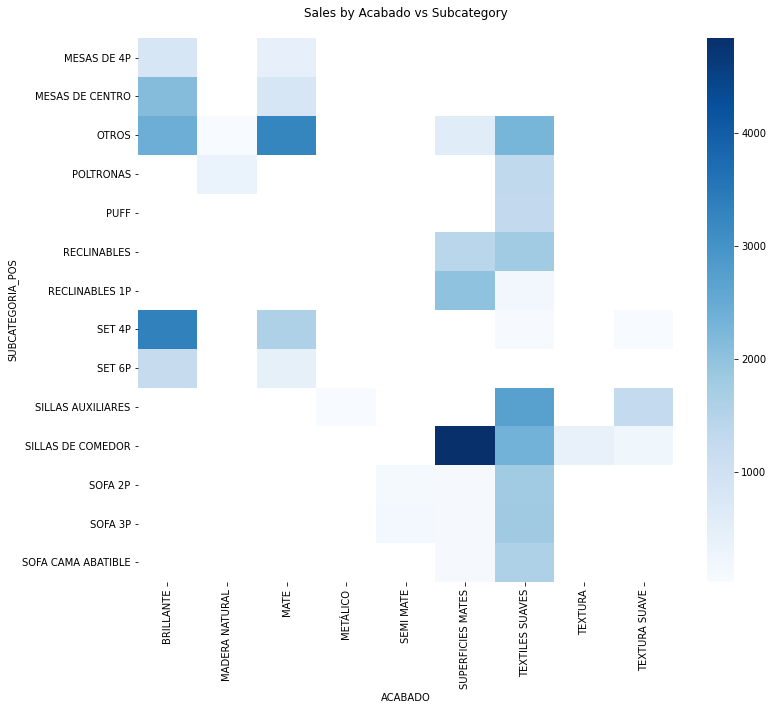

In [69]:
fig,ax=plt.subplots(figsize=(12,10))
plt.title('Sales by Acabado vs Subcategory\n')
sns.heatmap(pd.pivot_table(data=references,index='SUBCATEGORIA_POS',columns='ACABADO',values='CANTIDAD',aggfunc='sum'),cmap='Blues', robust=True)

## Stock

In [70]:
stock_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 943 entries, 0 to 942
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                943 non-null    object 
 1   REF               943 non-null    object 
 2   CANTIDAD          943 non-null    int64  
 3   DETALLE_1         879 non-null    float64
 4   DETALLE_2         75 non-null     float64
 5   ITEM              452 non-null    float64
 6   DESCRIPCION       452 non-null    object 
 7   CATEGORIA         452 non-null    object 
 8   SUBCATEGORIA      452 non-null    object 
 9   VIGENCIA          452 non-null    object 
 10  ORIGEN            452 non-null    object 
 11  ESTILO            452 non-null    object 
 12  MATERIAL          452 non-null    object 
 13  ACABADO           452 non-null    object 
 14  PUESTOS           312 non-null    float64
 15  COLOR             452 non-null    object 
 16  ANCHO             452 non-null    float64
 1

In [71]:
stock_prod.describe(include='O')

ID            REF         DESCRIPCION      CATEGORIA  \
count      943            943                 452            452   
unique     902            941                 349              4   
top     D00069  XN0571:00009:  SOFA RECLINO MAHON  SALAS Y SOFAS   
freq         5              3                   6            201   

             SUBCATEGORIA       VIGENCIA     ORIGEN   ESTILO    MATERIAL  \
count                 452            452        452      452         452   
unique                 37              3          3        4          16   
top     SILLAS DE COMEDOR  DESCONTINUADO  IMPORTADO  MODERNO  MICROFIBRA   
freq                   80            223        414      235         123   

                ACABADO  COLOR                DESC_LARGA SUBCATEGORIA_POS  \
count               452    452                       452              943   
unique                9     54                       439               14   
top     TEXTILES SUAVES  NEGRO  SILLA AUXILIAR AMALFI CF            OTROS   
freq                122     82                         3              638   

       COLOR_POS MATERIAL_POS  
count        943          943  
unique        11            6  
top         OTRO        otros  
freq         618          539

In [72]:
stock_prod.sort_values('CANTIDAD',ascending=False).head(10)

ID            REF  CANTIDAD  DETALLE_1  DETALLE_2     ITEM  \
370  XZ0848  XZ0848:00009:       239        9.0        NaN   5867.0   
98   XA0384  XA0384:00005:       202        5.0        NaN  16938.0   
340  XZ0505  XZ0505:00009:       197        9.0        NaN    652.0   
74   XZ0573  XZ0573:00005:       175        5.0        NaN  18627.0   
737  XA0395  XA0395:00046:       135       46.0        NaN  16986.0   
223  XC0052       XC0052::       133        NaN        NaN  19859.0   
738  XA0396  XA0396:00108:       129      108.0        NaN  16987.0   
424  XZ0191  XZ0191:00046:       127       46.0        NaN      NaN   
422  XZ0187  XZ0187:00046:       122       46.0        NaN      NaN   
692  XA0746  XA0746:00023:       116       23.0        NaN  18404.0   

              DESCRIPCION      CATEGORIA       SUBCATEGORIA       VIGENCIA  \
370   SILLA COMEDOR DALEY      COMEDORES  SILLAS DE COMEDOR  DESCONTINUADO   
98        SILLA BAR ALDIS      COMEDORES      SILLAS DE BAR          LINEA   
340  SILLA COMEDOR WASIMA      COMEDORES  SILLAS DE COMEDOR  DESCONTINUADO   
74    MESA COMEDOR JARITA      COMEDORES        MESAS DE 4P          LINEA   
737  SILLA AUXILIAR KANTI  SALAS Y SOFAS  SILLAS AUXILIARES          LINEA   
223           SILLA NAEVA      COMEDORES  SILLAS DE COMEDOR        NOVEDAD   
738  SILLA AUXILIAR KANTI  SALAS Y SOFAS  SILLAS AUXILIARES          LINEA   
424                   NaN            NaN                NaN            NaN   
422                   NaN            NaN                NaN            NaN   
692   SILLA RECLINO JUNKO  SALAS Y SOFAS     RECLINABLES 1P  DESCONTINUADO   

        ORIGEN         ESTILO    MATERIAL            ACABADO  PUESTOS  \
370  IMPORTADO        MODERNO   SINTÉTICO  SUPERFICIES MATES      1.0   
98   IMPORTADO  CONTEMPORÁNEO  MICROFIBRA    TEXTILES SUAVES      1.0   
340  IMPORTADO        MODERNO   SINTÉTICO  SUPERFICIES MATES      1.0   
74   IMPORTADO        MODERNO      VIDRIO          BRILLANTE      4.0   
737  IMPORTADO  CONTEMPORÁNEO  MICROFIBRA    TEXTILES SUAVES      1.0   
223  IMPORTADO  CONTEMPORÁNEO  MICROFIBRA    TEXTILES SUAVES      1.0   
738  IMPORTADO  CONTEMPORÁNEO  MICROFIBRA    TEXTILES SUAVES      1.0   
424        NaN            NaN         NaN                NaN      NaN   
422        NaN            NaN         NaN                NaN      NaN   
692  IMPORTADO        CLÁSICO   SINTÉTICO  SUPERFICIES MATES      1.0   

        COLOR  ANCHO   ALTO  FONDO                    DESC_LARGA  \
370      CAFE   42.0   96.0   42.0        SILLA COMEDOR DALEY CF   
98      NEGRO   42.0  105.0   58.0         SILLA BAR ALDIS NG 2C   
340      CAFE   45.0   95.0   45.0       SILLA COMEDOR WASIMA CF   
74      NEGRO  120.0   76.0   70.0     MESA COMEDOR JARITA NG 2C   
737      AZUL   44.0   78.0   50.0  SILLA AUXILIAR KANTI TELA AZ   
223     NEGRO   44.0   86.0   42.0      SILLA COMEDOR NAEVA GRIS   
738  AMARILLO   44.0   78.0   50.0  SILLA AUXILIAR KANTI TELA AM   
424       NaN    NaN    NaN    NaN                           NaN   
422       NaN    NaN    NaN    NaN                           NaN   
692      CAFE   89.0   90.0   70.0    SILLA RECLINO JUNKO CF OSC   

      SUBCATEGORIA_POS COLOR_POS MATERIAL_POS  
370  SILLAS DE COMEDOR      CAFE    SINTÉTICO  
98               OTROS     NEGRO   MICROFIBRA  
340  SILLAS DE COMEDOR      CAFE    SINTÉTICO  
74         MESAS DE 4P     NEGRO       VIDRIO  
737  SILLAS AUXILIARES      AZUL   MICROFIBRA  
223  SILLAS DE COMEDOR     NEGRO   MICROFIBRA  
738  SILLAS AUXILIARES  AMARILLO   MICROFIBRA  
424              OTROS      OTRO        otros  
422              OTROS      OTRO        otros  
692     RECLINABLES 1P      CAFE    SINTÉTICO

In [73]:
stock_prod.head(1)

ID            REF  CANTIDAD  DETALLE_1  DETALLE_2     ITEM  \
0  XA0669  XA0669:00189:         2      189.0        NaN  15999.0   

         DESCRIPCION CATEGORIA SUBCATEGORIA VIGENCIA     ORIGEN  \
0  BIBLIOTECA STEFAN   ESTUDIO  BIBLIOTECAS    LINEA  IMPORTADO   

          ESTILO         MATERIAL ACABADO  PUESTOS  COLOR  ANCHO  ALTO  FONDO  \
0  CONTEMPORÁNEO  MADERA LAMINADA    MATE      NaN  ROBLE   40.0  55.0   41.0   

                            DESC_LARGA SUBCATEGORIA_POS COLOR_POS  \
0  BIFET BIBLIOTECA STEFAN ROBLE 2 COL            OTROS      OTRO   

      MATERIAL_POS  
0  MADERA LAMINADA

In [74]:
aux1=stock_prod.groupby(['ORIGEN'])['CANTIDAD'].sum().sort_values(ascending=False).to_frame().head(10)


aux2=stock_prod.groupby(['ESTILO'])['CANTIDAD'].sum().sort_values(ascending=False).to_frame().head(10)

aux3=stock_prod.groupby(['VIGENCIA'])['CANTIDAD'].sum().sort_values(ascending=False).to_frame().head(10)

aux4=stock_prod.groupby(['ACABADO'])['CANTIDAD'].sum().sort_values(ascending=False).to_frame().head(10)
aux45=stock_prod.groupby(['MATERIAL_POS'])['CANTIDAD'].sum().sort_values(ascending=False).to_frame().head(10)
aux5=stock_prod.groupby(['COLOR_POS'])['CANTIDAD'].sum().sort_values(ascending=False).to_frame().head(10)
aux6=stock_prod.groupby(['PUESTOS'])['CANTIDAD'].sum().sort_values(ascending=False).to_frame().head(10)
display_side_by_side(aux1,aux2,aux3,aux4,aux45,aux5,aux6)

CANTIDAD 
 
 
 ORIGEN 
 
 
 
 
 
 IMPORTADO 
 6876 
 
 
 MANUFACTURADO 
 67 
 
 
 NACIONAL 
 12 
 
 
 
 
 
 
 CANTIDAD 
 
 
 ESTILO 
 
 
 
 
 
 MODERNO 
 3588 
 
 
 CONTEMPORÁNEO 
 2569 
 
 
 CLÁSICO 
 474 
 
 
 C+M - CLÁSICO + MODERNO 
 324 
 
 
 
 
 
 
 CANTIDAD 
 
 
 VIGENCIA 
 
 
 
 
 
 DESCONTINUADO 
 3068 
 
 
 NOVEDAD 
 2183 
 
 
 LINEA 
 1704 
 
 
 
 
 
 
 CANTIDAD 
 
 
 ACABADO 
 
 
 
 
 
 SUPERFICIES MATES 
 1903 
 
 
 TEXTILES SUAVES 
 1878 
 
 
 MATE 
 1738 
 
 
 BRILLANTE 
 1319 
 
 
 TEXTURA SUAVE 
 91 
 
 
 MADERA NATURAL 
 12 
 
 
 SEMI MATE 
 6 
 
 
 TEXTURA 
 6 
 
 
 METÁLICO 
 2 
 
 
 
 
 
 
 CANTIDAD 
 
 
 MATERIAL_POS 
 
 
 
 
 
 otros 
 6089 
 
 
 SINTÉTICO 
 1908 
 
 
 MICROFIBRA 
 1893 
 
 
 VIDRIO 
 1281 
 
 
 MADERA LAMINADA 
 1117 
 
 
 METAL + VIDRIO 
 114 
 
 
 
 
 
 
 CANTIDAD 
 
 
 COLOR_POS 
 
 
 
 
 
 OTRO 
 7119 
 
 
 NEGRO 
 1684 
 
 
 CAFE 
 1473 
 
 
 GRIS 
 596 
 
 
 BLANCO 
 543 
 
 
 AZUL 
 331 
 
 
 AMARILLO 
 234 
 
 
 ROJO 
 141 
 
 
 MIEL 
 105 
 
 
 CRISTAL 
 103 
 
 
 
 
 
 
 CANTIDAD 
 
 
 PUESTOS 
 
 
 
 
 
 1.0 
 3242 
 
 
 4.0 
 849 
 
 
 6.0 
 491 
 
 
 3.0 
 377 
 
 
 2.0 
 336

**1. Category**

<AxesSubplot:title={'center':'Stock Units by Category'}, xlabel='CATEGORIA', ylabel='CANTIDAD'>

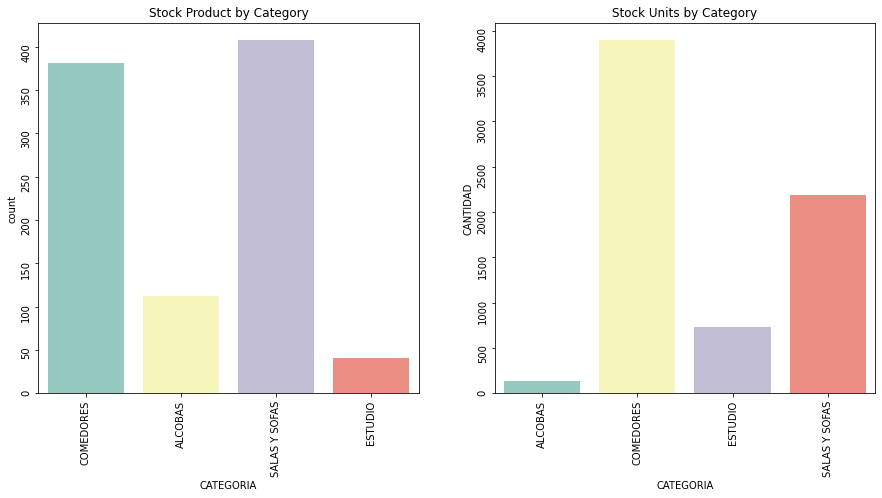

In [75]:
a = stock_prod.groupby('CATEGORIA')['CANTIDAD'].sum().to_frame().reset_index()

f, ax = plt.subplots(2,2, figsize=(15,15))
ax[1,0].set_visible(False)
ax[1,1].set_visible(False)

ax[0,0].set_title('Stock Product by Category')
ax[0,0].tick_params(labelrotation=90)
sns.countplot(x="CATEGORIA", data=stock, palette="Set3", ax=ax[0,0])

ax[0,1].set_title('Stock Units by Category')
ax[0,1].tick_params(labelrotation=90)
sns.barplot(x="CATEGORIA", y='CANTIDAD', data=a, palette="Set3",ax=ax[0,1])

**2. Subcategory**

<AxesSubplot:title={'center':'Stock Units by Subcategory'}, xlabel='SUBCATEGORIA_POS', ylabel='CANTIDAD'>

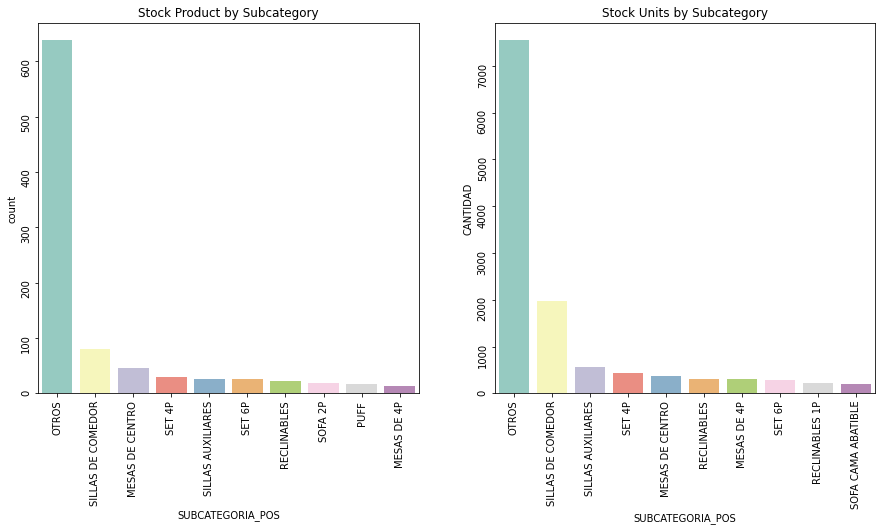

In [76]:
a = stock_prod.groupby('SUBCATEGORIA_POS')['CANTIDAD'].sum().sort_values(ascending=False).to_frame().reset_index().head(10)

f, ax = plt.subplots(2,2, figsize=(15,15))
ax[1,0].set_visible(False)
ax[1,1].set_visible(False)

ax[0,0].set_title('Stock Product by Subcategory')
ax[0,0].tick_params(labelrotation=90)
sns.countplot(x="SUBCATEGORIA_POS", data=stock_prod, palette="Set3", order = stock_prod['SUBCATEGORIA_POS'].value_counts().head(10).index, ax=ax[0,0])

ax[0,1].set_title('Stock Units by Subcategory')
ax[0,1].tick_params(labelrotation=90)
sns.barplot(x="SUBCATEGORIA_POS", y='CANTIDAD', data=a, palette="Set3",ax=ax[0,1])

**3. Frequency Tables Category|Subcategory**

Text(0.5, 1.0, 'stock_prod Product\n')

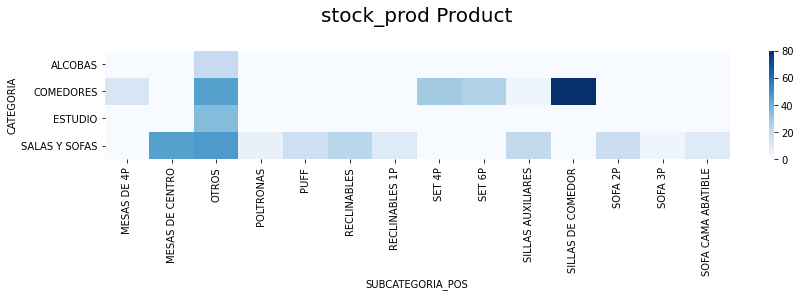

In [77]:
fig,ax = plt.subplots(figsize=(14,2))
sns.heatmap(pd.crosstab(stock_prod['CATEGORIA'], stock_prod['SUBCATEGORIA_POS']), cmap='Blues')
plt.title('stock_prod Product\n',fontsize=20)

Text(0.5, 1.0, 'stock_prod Units\n')

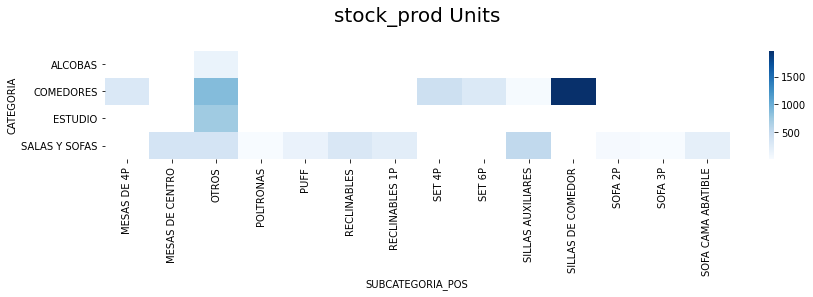

In [78]:
fig,ax = plt.subplots(figsize=(14,2))
stock_prod_pivot = pd.pivot_table(data=stock_prod, index='CATEGORIA', columns='SUBCATEGORIA_POS', values='CANTIDAD', aggfunc='sum')
sns.heatmap(stock_prod_pivot,cmap='Blues')
plt.title('stock_prod Units\n',fontsize=20)

**4. Subcategories vs other variables.**

Text(0.5, 1.0, 'Unit salesfrom Subcategories and "acabado"')

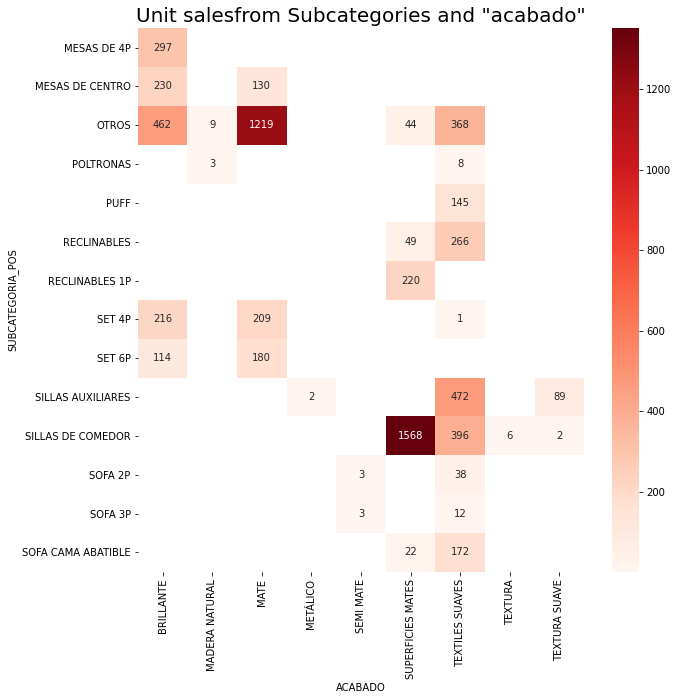

In [79]:
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(pd.pivot_table(data=stock_prod,index='SUBCATEGORIA_POS',columns='ACABADO',values='CANTIDAD',aggfunc='sum'),cmap='Reds',robust=True,annot=True,fmt='g')
plt.title('Unit salesfrom Subcategories and "acabado"', fontsize=20)


Text(0.5, 1.0, 'Unit stock_prod from Subcategories and material')

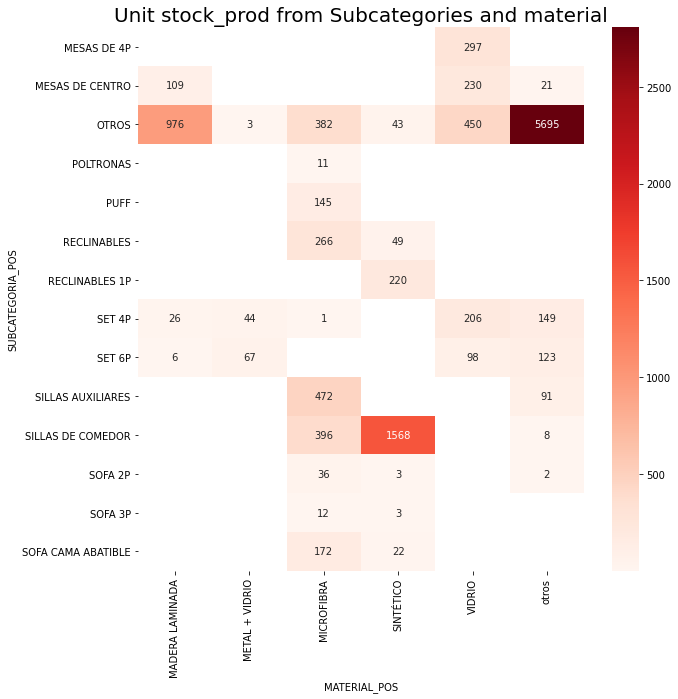

In [80]:
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(pd.pivot_table(data=stock_prod,index='SUBCATEGORIA_POS',columns='MATERIAL_POS',values='CANTIDAD',aggfunc='sum'),cmap='Reds',robust=True,annot=True,fmt='g')
plt.title('Unit stock_prod from Subcategories and material', fontsize=20)


Text(0.5, 1.0, 'Unit stock_prod from Subcategories and PUESTOS')

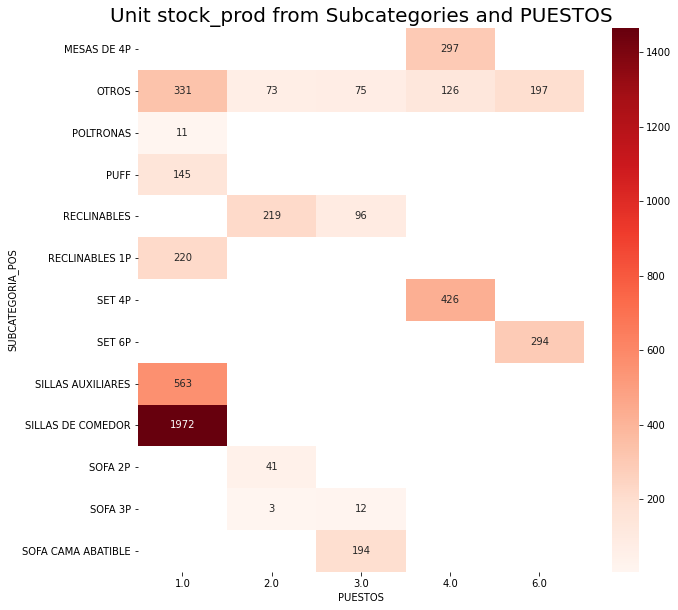

In [81]:
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(pd.pivot_table(data=stock_prod,index='SUBCATEGORIA_POS',columns='PUESTOS',values='CANTIDAD',aggfunc='sum'),cmap='Reds',robust=True,annot=True,fmt='g')
plt.title('Unit stock_prod from Subcategories and PUESTOS', fontsize=20)

Text(0.5, 1.0, 'Unit stock_prod from Subcategories and color')

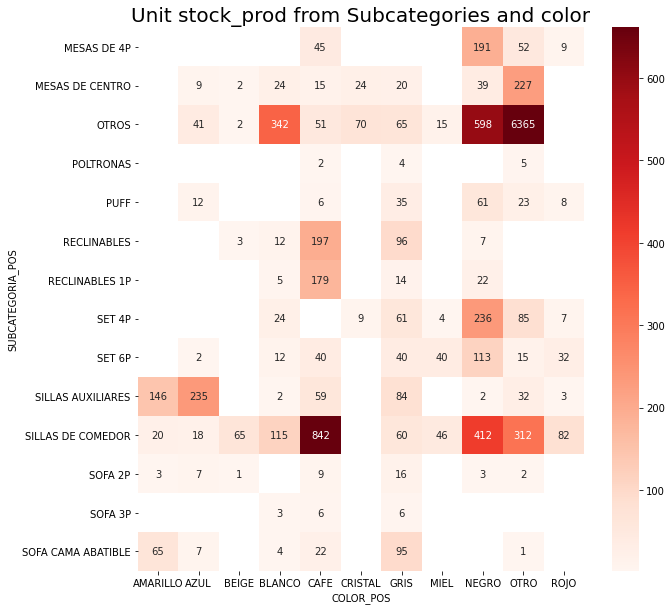

In [82]:
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(pd.pivot_table(data=stock_prod,index='SUBCATEGORIA_POS',columns='COLOR_POS',values='CANTIDAD',aggfunc='sum'),cmap='Reds',robust=True,annot=True,fmt='g')
plt.title('Unit stock_prod from Subcategories and color', fontsize=20)

Text(0.5, 1.0, 'Frecuency of Subcategories and colors')

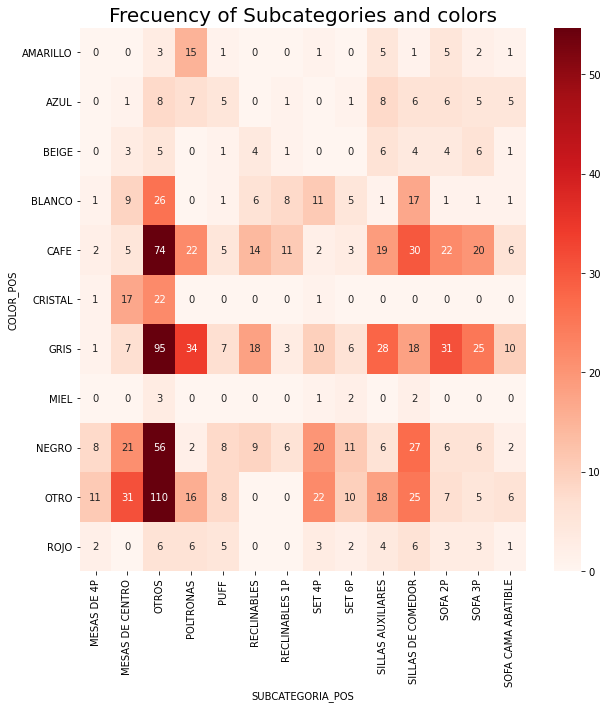

In [83]:
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(pd.crosstab(products['COLOR_POS'],products['SUBCATEGORIA_POS']),cmap='Reds',robust=True,annot=True,fmt='g')
plt.title('Frecuency of Subcategories and colors', fontsize=20)